In [14]:
import time
from tqdm import tqdm, tqdm_pandas

tqdm.pandas(tqdm())

import numpy as np
import pandas as pd
import splat
from splat import empirical
from splat import simulate
from splat import evolve
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
font = {'family' : 'serif',
        'serif':[],
        'weight' : 'bold',
        'size'   : 16}
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['agg.path.chunksize'] = 10000
sns.set_style('white')
pd.options.display.max_columns = 999
%matplotlib inline


0it [00:00, ?it/s]

In [15]:
from platform import python_version
splat.checkAccess(), splat.VERSION

(True, '2018.07.24')

In [16]:
path = '/Users/daniella/Research/M7L5Sample/LFsimulation/'

In [17]:
sample = pd.read_csv("finalsample_bonafide_M7L5_25pc.csv")
sample.shape

(368, 287)

In [18]:
def absmag(appmag,appmag_e, dist, dist_e):
    M = appmag - 5*np.log10(dist) + 5
    Merr = np.sqrt(appmag_e**2 + 5*dist_e**2/(dist*np.log(10))**2)
    return [M,Merr]

In [19]:
def poisson_unc(Nsamp):
    plus = 0.5 + np.sqrt(Nsamp+0.5)
    minus = -0.5 + np.sqrt(Nsamp+0.5)
    return [plus,minus]

In [20]:
sample['bestdisttag'].unique()

array(['gaia', 'NIRdist', 'SIMBADplx', 'WISEplx'], dtype=object)

In [21]:
sample['disttag'] = sample['bestdisttag']
sample['disttag'] = sample['disttag'].replace('gaia','plx')
sample['disttag'] = sample['disttag'].replace('SIMBADplx','plx')
sample['disttag'] = sample['disttag'].replace('NIRdist','phot')

In [22]:
condJplx = (sample['adJflag'] == '2MASS') & (sample['disttag'] == 'plx')
condJphot = (sample['adJflag'] == '2MASS') & (sample['disttag'] == 'phot')

sample['MJflag'] = np.nan
sample['MHflag'] = np.nan
sample['MKflag'] = np.nan

sample['MJ'],sample['MJe'] = absmag(sample['adoptedJ'],sample['adoptedJE'],sample['bestdist'],sample['bestdistE'])
sample['MJflag'][condJplx] = 'plx'
sample['MJflag'][condJphot] = 'phot'
sample['MH'],sample['MHe'] = absmag(sample['adoptedH'],sample['adoptedHE'],sample['bestdist'],sample['bestdistE'])
sample['MHflag'][condJplx] = 'plx'
sample['MHflag'][condJphot] = 'phot'
sample['MK'],sample['MKe'] = absmag(sample['adoptedK'],sample['adoptedKE'],sample['bestdist'],sample['bestdistE'])
sample['MKflag'][condJplx] = 'plx'
sample['MKflag'][condJphot] = 'phot'

In [23]:
sample[['NAME','adoptedJ','adoptedJE','bestdist','bestdistE','MJ']][sample['MJ'].isnull()]

,NAME,adoptedJ,adoptedJE,bestdist,bestdistE,MJ
138,GJ 1116B,NaN,NaN,5.126006,0.004609,NaN
328,Gl 779B,NaN,NaN,17.238408,0.267446,NaN


In [24]:
ind = sample[sample['MJ'].isnull()].index
lfsamp = sample.drop(ind,0).reset_index()

Text(0.5,0,'$M_{Ks}$')

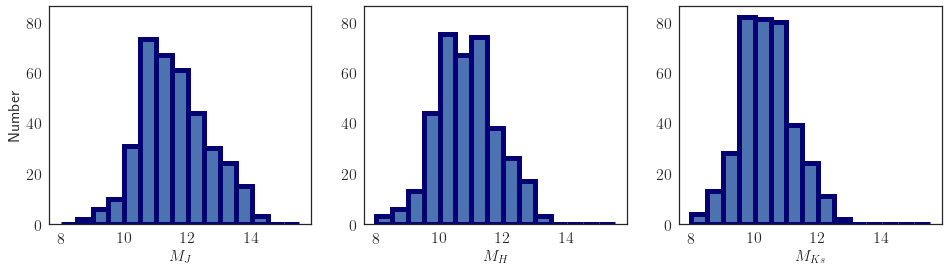

In [25]:
fig = plt.figure(figsize=(16,4))
ax1 = plt.subplot(131)
bins = np.arange(16)/2+8
plt.hist(lfsamp['MJ'], bins=bins,edgecolor=sns.xkcd_rgb["deep blue"],linewidth=5)
plt.xlabel("$M_J$",fontsize=16)
plt.ylabel("Number",fontsize=16)

ax2 = plt.subplot(132,sharey=ax1)
bins = np.arange(16)/2+8
plt.hist(lfsamp['MH'], bins=bins,edgecolor=sns.xkcd_rgb["deep blue"],linewidth=5)
plt.xlabel("$M_H$",fontsize=16)
#plt.ylabel("Number",fontsize=16)

ax3 = plt.subplot(133,sharey=ax1)
bins = np.arange(16)/2+8
plt.hist(lfsamp['MK'], bins=bins,edgecolor=sns.xkcd_rgb["deep blue"],linewidth=5)
plt.xlabel("$M_{Ks}$",fontsize=16)
#plt.ylabel("Number",fontsize=16)

#### Simulation for corrections

**Idea:**
Stars have an intrinsic brightness (i.e. absolute magnitude), are defined by a spectral type, and are located at a certain true distance. When we do measurements from Earth, we observe values lying in a normal distribution centered around the true physical parameters. Especially around the edges of our sample (M7-L5, 25pc) this means that some stars will contaminate or be missed in our census due to unresolved binarity, measurement uncertainty, etc. Therefore, to correct for these sources trickling in and out, we will simulate a population of stars, give them spectral types and distances, and absolute magnitudes corresponding to those spectral types. These are the true values. Our measurements from Earth will have an uncertainty around the true values, along with other calculated values. At the end, we simulate our cuts and see how many objects are proportionally trickling in and out of the sample

**Plan:**
- Set up true values:
    - distances: randomly drawn from a $d^3$ distribution and up to 50 pc.
    - spts: randomly drawn from a uniform distribution between M5-L7, giving 2 subtypes of wiggle room.
    - absolute magnitudes: calculate from spectral types and empirical relations, plus an uncertainty from a distribution as wide as the empirical relation uncertainty
    - parallaxes: distance is not an observable, but parallax is. Calculate "true" parallax.
- Add in unresolved binaries:
    - unresolved binaries affect the selection function by changing the absolute and apparent magnitude of the primary, thus appearing to be brighter and possibly closer if no parallax is known.
    - binary fraction: pick 20%, good enough for our purposes. 
    - magnitude offset distribution: 
    - draw magnitude offsets from a magnitude offset distribution to be added to select 20% of sample (primaries):
        - draw masses from an IMF
        - draw ages from a uniform age distribution
        - calculate teffs with evolutionary models
        - draw mass ratios from Allen 2007
        - calculate secondary masses
        - calculate teffs2
        - calculate spectral types 1 and 2 from teffs
        - calculate mag offsets between combined magnitudes and primary magnitude. Add this offset to primaries.
- Calculate "observed" values. These are our measurements/observables:
    - observed spectral types: add uncertainty offset to spectral types, with a scale equal to the scatter between optical and SpeX spectral types. 
    - observed apparent magnitudes: with new absolute magnitudes (including unresolved binaries) and true distances. Also, add uncertainty with a scale equal to 0.05mag.
    - observed parallaxes: add uncertainty to true parallaxes, from normal distribution centered around zero with a scale equal to the scatter in parallaxes from data.
- Calculate inferred values. These are the parameters we normally calculate from observations:
    - inferred trigonometric distances: from observed parallaxes.
    - inferred absolute magnitudes:
        - from inferred distances and apparent magnitudes, and 
        - from empirical relations and observed spectral types
    - inferred spectrophotometric distances (for objects without parallax): from inferred absolute magnitudes and apparent magnitudes
- Now that we have observed and inferred values, make sample selections:
    - distance cut:
        - the true sample: cut on true distance at 25pc. These are the objects that truly belong in the sample.
        - trigonometric distance cut: cut on inferred distance *from parallaxes* at 25pc.
        - spectrophotometric distance cut: cut on inferred spectrophotometric distance at 25pc.
    - spectral type cut:
        - 
        


In [40]:
##variables and constants

nsim = 1e6
dlim = 25.
spt_range = [17,25]
spt_offset = 2.
dsim = 2.*dlim
spt_abs_relation = 'dupuy'
spt_abs_relation_unc = 0.4
filter_name = ['2MASS J','2MASS H','2MASS KS']
spt_uncertainty = 0.89 #From paper
mag_uncertainty = 0.05
plx_uncertainty = 5.

emodel = 'burrows'
spt_teff_relation = 'filippazzo'
binary_fraction = 0.2
q_relation = 'allen'

spt_bin = 0.5
spt_x = np.arange(spt_range[0],spt_range[1],spt_bin)

- Set up true values:
    - distances: randomly drawn from a $d^3$ distribution and up to 50 pc.
    - spts: randomly drawn from a uniform distribution between M5-L7, giving 2 subtypes of wiggle room.
    - absolute magnitudes: calculate from spectral types and empirical relations, plus an uncertainty from a distribution as wide as the empirical relation uncertainty
    - parallaxes: distance is not an observable, but parallax is. Calculate "true" parallax.


In [39]:
nsamp = 10**6
sptn = np.arange(13)+15
dmax = 50.
dlim = 25.

In [12]:
def spt2mag(sptn):
    #http://iopscience.iop.org/article/10.1086/340697/fulltext/
    if (sptn <= 17) & (sptn >= 15):
        spt = sptn - 10
        return 5.73 + 0.74*spt
spt2mag(15)

9.43

In [13]:
def spt2teff(sptn):
    #http://adsabs.harvard.edu/abs/2017ApJS..231...15D
    if (sptn <=17) & (sptn >= 15):
        spt = sptn-10
        return 4251.0-238.03*spt+4.582*spt**2

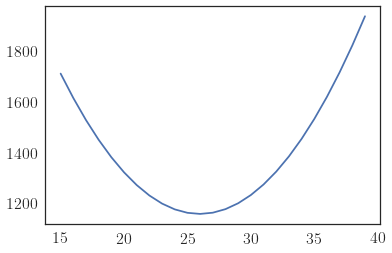

In [14]:
x = np.arange(15,40,1)
y = 4251.0-238.03*x+4.582*x**2
plt.plot(x,y)

In [15]:
def teff2spt(teff):
        spt = sptn-10
        return 4251.0-238.03*spt+4.582*spt**2    

In [16]:
#pd.read_table("/Users/daniella/Research/Relations/dupuy_liu2012_tab14.txt",delim_whitespace=True)

In [17]:
paramsdf = pd.DataFrame(index=np.arange(len(sptn)),columns=['sptn','MJ','MJe','MH','MHe','MK','MKe'])
paramsdf['sptn'] = sptn
paramsdf['MJ'] = paramsdf['sptn'].map(lambda x: empirical.typeToMag(x,'2MASS J',ref='dupuy')[0])
paramsdf['MH'] = paramsdf['sptn'].map(lambda x: empirical.typeToMag(x,'2MASS H',ref='dupuy')[0])
paramsdf['MK'] = paramsdf['sptn'].map(lambda x: empirical.typeToMag(x,'2MASS KS',ref='dupuy')[0])
paramsdf['MJe'] = np.ones(len(paramsdf))*0.4
paramsdf['MHe'] = np.ones(len(paramsdf))*0.4
paramsdf['MKe'] = np.ones(len(paramsdf))*0.4
paramsdf.loc[0,'MJ'] = spt2mag(paramsdf.loc[0,'sptn'])
paramsdf.loc[0,'MH'] = np.nan
paramsdf.loc[0,'MK'] = np.nan

In [18]:
paramsdf

,sptn,MJ,MJe,MH,MHe,MK,MKe
0,15,9.430000,0.4,NaN,0.4,NaN,0.4
1,16,10.021179,0.4,9.464701,0.4,9.387741,0.4
2,17,10.593666,0.4,9.998806,0.4,9.566795,0.4
3,18,10.988594,0.4,10.339530,0.4,9.807434,0.4
4,19,11.308431,0.4,10.597901,0.4,10.090337,0.4
5,20,11.618346,0.4,10.843910,0.4,10.398740,0.4
6,21,11.953508,0.4,11.115210,0.4,10.718444,0.4
7,22,12.325816,0.4,11.425014,0.4,11.037807,0.4
8,23,12.730065,0.4,11.769185,0.4,11.347750,0.4
9,24,13.149549,0.4,12.132533,0.4,11.641754,0.4


In [19]:
t0 = time.time()

simdf = pd.DataFrame(index=np.arange(nsamp))
print('assigning distances...')
simdf['true_dist'] = np.random.power(3,size=nsamp)*dmax
print(time.time()-t0)
print('assigning spectral types...')
simdf['true_sptn'] = np.random.uniform(high=27,low=15,size=nsamp)
print(time.time()-t0)
print('calculating parallaxes...')
simdf['true_plx'] = 1000./simdf['true_dist']
#i think assigning values is faster than calculating them every time
print(time.time()-t0)
print('calculating absolute magnitudes in J...')
simdf['rel_MJ'] = simdf['true_sptn'].map(lambda x: paramsdf['MJ'][paramsdf['sptn'] == np.round(x,0)].values[0])
print(time.time()-t0)
print('calculating absolute magnitudes in H...')
simdf['rel_MH'] = simdf['true_sptn'].map(lambda x: paramsdf['MH'][paramsdf['sptn'] == np.round(x,0)].values[0])
print(time.time()-t0)
print('calculating absolute magnitudes in K...')
simdf['rel_MK'] = simdf['true_sptn'].map(lambda x: paramsdf['MK'][paramsdf['sptn'] == np.round(x,0)].values[0])
print(time.time()-t0)
print('adding uncertainties to absolute magnitudes in J...')
simdf['true_MJ'] = simdf['rel_MJ'] + np.random.normal(loc=0,scale=0.4,size=nsamp)
print(time.time()-t0)
print('adding uncertainties to absolute magnitudes in H...')
simdf['true_MH'] = simdf['rel_MH'] + np.random.normal(loc=0,scale=0.4,size=nsamp)
print(time.time()-t0)
print('adding uncertainties to absolute magnitudes in K...')
simdf['true_MK'] = simdf['rel_MK'] + np.random.normal(loc=0,scale=0.4,size=nsamp)
print(time.time()-t0)  #1297.5610971450806 seconds
print('done!')

assigning distances...
0.10326480865478516
assigning spectral types...
0.12062788009643555
calculating parallaxes...
0.14697980880737305
calculating absolute magnitudes in J...
292.92876386642456
calculating absolute magnitudes in H...
587.8268828392029
calculating absolute magnitudes in K...
900.1948349475861
adding uncertainties to absolute magnitudes in J...
900.2691259384155
adding uncertainties to absolute magnitudes in H...
900.3065717220306
adding uncertainties to absolute magnitudes in K...
900.3405478000641
done!


(array([2.20000e+01, 8.44000e+02, 1.45750e+04, 1.02585e+05, 2.97749e+05,
        3.60770e+05, 1.81554e+05, 3.84690e+04, 3.31300e+03, 1.19000e+02]),
 array([-2.02911023, -1.64011954, -1.25112885, -0.86213816, -0.47314747,
        -0.08415678,  0.30483391,  0.6938246 ,  1.0828153 ,  1.47180599,
         1.86079668]),
 <a list of 10 Patch objects>)

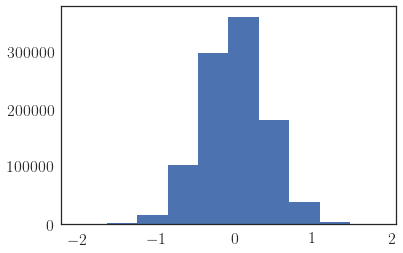

In [20]:
plt.hist(np.random.normal(loc=0,scale=0.4,size=nsamp))

(array([  1332.,   7787.,  20144.,  38240.,  61999.,  91644., 126311.,
        168451., 215928., 268164.]),
 array([ 0.59388487,  5.5344962 , 10.47510754, 15.41571887, 20.35633021,
        25.29694154, 30.23755288, 35.17816422, 40.11877555, 45.05938689,
        49.99999822]),
 <a list of 10 Patch objects>)

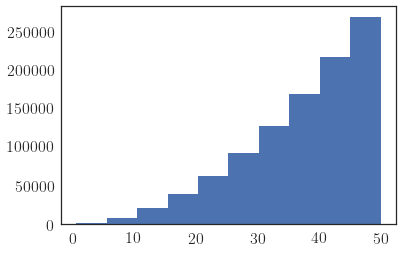

In [21]:
plt.hist(simdf['true_dist'])

In [22]:
simdf.head()

,true_dist,true_sptn,true_plx,rel_MJ,rel_MH,rel_MK,true_MJ,true_MH,true_MK
0,46.816363,16.985720,21.360053,10.593666,9.998806,9.566795,11.073661,10.365100,9.592298
1,46.306245,24.842481,21.595359,13.561097,12.494301,11.915861,13.276187,12.605042,11.932932
2,47.195860,21.642065,21.188299,12.325816,11.425014,11.037807,13.350677,11.055018,10.311983
3,31.257796,17.545232,31.992019,10.988594,10.339530,9.807434,11.016476,10.178856,9.042091
4,34.645399,17.143474,28.863862,10.593666,9.998806,9.566795,10.851584,9.649616,9.763335


In [23]:
simdf[simdf['rel_MJ'].isnull()]

,true_dist,true_sptn,true_plx,rel_MJ,rel_MH,rel_MK,true_MJ,true_MH,true_MK


In [24]:
pwd

'/Users/daniella/Research/M7L5Sample'

In [25]:
!mkdir 'LFsimulation'

mkdir: LFsimulation: File exists


In [26]:
pwd

'/Users/daniella/Research/M7L5Sample'

In [27]:
simdf.to_csv("/Users/daniella/Research/M7L5Sample/LFsimulation/LFsim_step1_N1000000.csv",index=False)

In [28]:
simdf = pd.read_csv("/Users/daniella/Research/M7L5Sample/LFsimulation/LFsim_step1_N1000000.csv")
simdf.shape

(1000000, 9)

In [29]:
simdf.columns

Index(['true_dist', 'true_sptn', 'true_plx', 'rel_MJ', 'rel_MH', 'rel_MK',
       'true_MJ', 'true_MH', 'true_MK'],
      dtype='object')

- Add in unresolved binaries:
    - unresolved binaries affect the selection function by changing the absolute and apparent magnitude of the primary, thus appearing to be brighter and possibly closer if no parallax is known.
    - binary fraction: pick 20%, good enough for our purposes. 
    - magnitude offset distribution: 
    - draw magnitude offsets from a magnitude offset distribution to be added to select 20% of sample (primaries):
        - draw masses from an IMF
        - draw ages from a uniform age distribution
        - calculate teffs with evolutionary models
        - draw mass ratios from Allen 2007
        - calculate secondary masses
        - calculate teffs2
        - calculate spectral types 1 and 2 from teffs
        - calculate mag offsets between combined magnitudes and primary magnitude. Add this offset to primaries.


In [30]:
#magnitude difference between combined magnitude and primary magnitude = mag offset
def magdiff(mag1,mag2):
    magdiff = -2.5*np.log10(1+10**(0.4*(mag1-mag2)))
    return magdiff

In [31]:
simdf = simdf.assign(age=np.nan, q=np.nan, mass1=np.nan, mass2=np.nan, teff2=np.nan, spt2=np.nan, MJ2=np.nan,MH2=np.nan, MK2=np.nan, 
                     binary_flag=np.zeros(len(simdf)), combMJ=np.nan, combMH=np.nan, combMK=np.nan)

In [32]:
nbin = int(nsamp*0.20)

t0 = time.time()
simdf.loc[:nbin,'binary_flag'] = 1.
print('assigning ages...')
simdf['age'] = simulate.simulateAges(distribution='uniform',age_range=[0.5,10],num=nsamp)
print(time.time() - t0)
print('assigning mass ratios...')
simdf.loc[:nbin,'q'] = simulate.simulateMassRatios(distribution='allen',num=nbin+1)
print(time.time() - t0)
print('assigning primary temperatures...')
simdf.loc[:nbin,'teff1'] = simdf.loc[:nbin,'true_sptn'].map(lambda x: spt2teff(x) if x < 17 else empirical.typeToTeff(x,ref='Dupuy')[0].value)
print(time.time() - t0)
print('assigning primary masses (this takes time)...')
simdf.loc[:nbin,'mass1'] = evolve.modelParameters('burrows',teff=simdf.loc[:nbin,'teff1'], age=simdf.loc[:nbin,'age'])['mass'].value
print(time.time() - t0)
print('assigning secondary masses...')
simdf.loc[:nbin,'mass2'] = simdf.loc[:nbin,'mass1'].values*simdf.loc[:nbin,'q'].values
print(time.time()-t0)
print('assigning secondary temperatures (this takes time)...')
simdf.loc[:nbin,'teff2'] = evolve.modelParameters('burrows',m=simdf.loc[:nbin,'mass2'],a=simdf.loc[:nbin,'age'])['temperature'].value
print(time.time()-t0)
print('assigning secondary spectral types...')
simdf.loc[:nbin,'spt2'] = simdf.loc[:nbin,'teff2'].map(lambda x: empirical.typeToTeff(x,ref='Filippazzo',reverse=True)[0])
print(time.time()-t0)
print('assigning secondary absolute magntiudes...')
simdf.loc[:nbin,'MJ2'] = simdf.loc[:nbin,'spt2'].map(lambda x: spt2mag(x) if x < 16 else empirical.typeToMag(x,ref='Dupuy',filt='2MASS J')[0])+np.random.normal(loc=0,scale=spt_abs_relation_unc,size=nbin+1)
simdf.loc[:nbin,'MH2'] = simdf.loc[:nbin,'spt2'].map(lambda x: empirical.typeToMag(x,ref='Dupuy',filt='2MASS H')[0])+np.random.normal(loc=0,scale=spt_abs_relation_unc,size=nbin+1)
simdf.loc[:nbin,'MK2'] = simdf.loc[:nbin,'spt2'].map(lambda x: empirical.typeToMag(x,ref='Dupuy',filt='2MASS KS')[0])+np.random.normal(loc=0,scale=spt_abs_relation_unc,size=nbin+1)
print(time.time()-t0)
print('assigning combined absolute magntiudes...')
simdf.loc[:nbin,'combMJ'] = simdf['true_MJ'] - 2.5*np.log10(1+10**0.4*(simdf['MJ2']-simdf['true_MJ']))
simdf.loc[:nbin,'combMH'] = simdf['true_MH'] - 2.5*np.log10(1+10**0.4*(simdf['MH2']-simdf['true_MH']))
simdf.loc[:nbin,'combMK'] = simdf['true_MK'] - 2.5*np.log10(1+10**0.4*(simdf['MK2']-simdf['true_MK']))
simdf.loc[nbin:,'combMJ'] = simdf['true_MJ']
simdf.loc[nbin:,'combMH'] = simdf['true_MH']
simdf.loc[nbin:,'combMK'] = simdf['true_MK']
print(time.time()-t0)  # 18625.15999698639 seconds
print('done!')

assigning ages...
0.4150350093841553
assigning mass ratios...
0.4389381408691406
assigning primary temperatures...
6885.5051782131195
assigning primary masses (this takes time)...
9520.842211961746
assigning secondary masses...
9520.859390974045
assigning secondary temperatures (this takes time)...
13067.058119058609
assigning secondary spectral types...
14567.306974887848
assigning secondary absolute magntiudes...
19926.21860718727
assigning combined absolute magntiudes...
19926.565834999084
done!


In [33]:
19926.565834999084/3600

5.535157176388634

In [34]:
simdf.describe()

,true_dist,true_sptn,true_plx,rel_MJ,rel_MH,rel_MK,true_MJ,true_MH,true_MK,age,q,mass1,mass2,teff2,spt2,MJ2,MH2,MK2,binary_flag,combMJ,combMH,combMK,teff1
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,958217.000000,958217.000000,1000000.000000,958217.000000,958217.000000,1000000.000000,200001.000000,200001.000000,200001.000000,200001.000000,182392.000000,182392.000000,182392.000000,182392.000000,1000000.000000,977013.000000,939757.000000,939631.000000,200001.000000
mean,37.506858,21.004253,29.983609,12.004536,11.269400,10.808571,12.004473,11.269928,10.809114,5.049154,0.738639,0.082656,0.061056,1329.091656,30.676699,14.449159,13.882785,13.630338,0.200001,11.684617,10.918417,10.447050,2200.693950
std,9.679359,3.466244,16.856909,1.341228,1.067093,0.962100,1.399101,1.140107,1.042061,2.857749,0.199061,0.014117,0.019691,662.476380,6.655263,1.708206,1.985028,2.193492,0.400001,1.637154,1.439664,1.373443,514.137826
min,0.593885,15.000003,20.000001,9.430000,9.464701,9.387741,7.647719,7.795195,7.508691,0.100002,0.100130,0.020581,0.002726,212.831851,16.000011,8.799754,8.334779,7.947343,0.000000,4.720682,4.610630,4.383360,1441.749059
25%,31.505758,17.999948,22.011518,10.988594,10.339530,9.807434,10.950255,10.399732,9.940748,2.573205,0.611310,0.076435,0.047928,844.479159,25.228519,13.605544,12.533570,11.930552,0.000000,10.585361,10.031953,9.603758,1736.617656
50%,39.701339,21.007662,25.188068,11.953508,11.115210,10.718444,11.976565,11.218941,10.800207,5.046033,0.782209,0.079912,0.062852,1156.059982,32.926685,14.685799,13.979277,13.718782,0.000000,11.718330,10.959920,10.498946,2137.567167
75%,45.430760,24.011241,31.740229,13.149549,12.132533,11.641754,13.148941,12.180800,11.667650,7.523583,0.902873,0.087866,0.074046,1628.795934,36.664892,15.474526,15.354586,15.462966,0.000000,12.955948,11.998581,11.512084,2651.324742
max,49.999998,26.999999,1683.828053,14.261654,13.129546,12.401349,15.900489,14.849494,14.065451,9.999962,1.000000,0.131264,0.131020,3174.207090,38.999920,19.165390,19.083479,18.684637,1.000000,25.046597,21.240366,20.223835,3175.384390


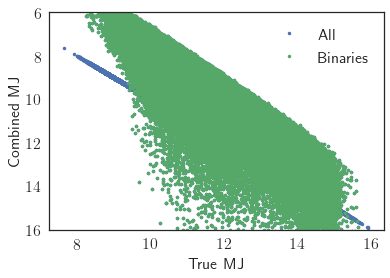

In [136]:
plt.plot(simdf['true_MJ'],simdf['combMJ'],'.')
plt.plot(simdf['true_MJ'][simdf['binary_flag'] == 1],simdf['combMJ'][simdf['binary_flag'] == 1],'.')
plt.xlabel('True MJ',fontsize=16)
plt.ylim(16,6)
plt.ylabel('Combined MJ',fontsize=16)
plt.legend(['All','Binaries'],fontsize=16)

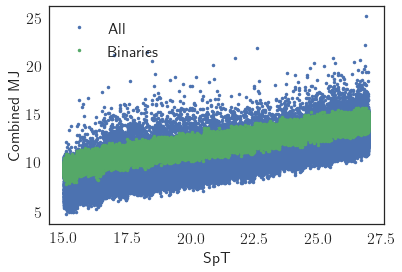

In [37]:
plt.plot(simdf['true_sptn'],simdf['combMJ'],'.')
plt.plot(simdf['true_sptn'][simdf['binary_flag'] == 1],simdf['true_MJ'][simdf['binary_flag'] == 1],'.')
plt.xlabel('SpT',fontsize=16)
plt.ylabel('Combined MJ',fontsize=16)
plt.legend(['All','Binaries'],fontsize=16)

Maybe abs mag scatter is too large

In [38]:
simdf.to_csv(path+'LFsim_step2_N1000000.csv',index=False)

- Calculate "observed" values. These are our measurements/observables:
    - observed spectral types: add uncertainty offset to spectral types, with a scale equal to the scatter between optical and SpeX spectral types. 
    - observed apparent magnitudes: with new absolute magnitudes (including unresolved binaries) and true distances. Also, add uncertainty with a scale equal to 0.05mag.
    - observed parallaxes: add uncertainty to true parallaxes, from normal distribution centered around zero with a scale equal to the scatter in parallaxes from data.


In [41]:
simdf = pd.read_csv(path+"LFsim_step2_N1000000.csv")
simdf.shape

(1000000, 23)

In [42]:
simdf.columns

Index(['true_dist', 'true_sptn', 'true_plx', 'rel_MJ', 'rel_MH', 'rel_MK',
       'true_MJ', 'true_MH', 'true_MK', 'age', 'q', 'mass1', 'mass2', 'teff2',
       'spt2', 'MJ2', 'MH2', 'MK2', 'binary_flag', 'combMJ', 'combMH',
       'combMK', 'teff1'],
      dtype='object')

In [132]:
t0 = time.time()
print('calculating observed spectral types...')
simdf['obs_sptn'] = simdf['true_sptn'] + np.random.normal(loc=0.,scale=spt_uncertainty,size=nsamp)
print(time.time()-t0)
print('calculating combined apparent magnitudes...')
simdf['comb_mJ'] = simdf['combMJ']+5*np.log10(simdf['true_dist']/10.)
simdf['comb_mH'] = simdf['combMH']+5*np.log10(simdf['true_dist']/10.)
simdf['comb_mK'] = simdf['combMK']+5*np.log10(simdf['true_dist']/10.)
print(time.time()-t0)
print('calculating observed combined apparent magnitudes...')
simdf['obs_comb_mJ'] = simdf['comb_mJ'] + np.random.normal(loc=0.,scale=mag_uncertainty,size=nsamp)
simdf['obs_comb_mH'] = simdf['comb_mH'] + np.random.normal(loc=0.,scale=mag_uncertainty,size=nsamp)
simdf['obs_comb_mK'] = simdf['comb_mK'] + np.random.normal(loc=0.,scale=mag_uncertainty,size=nsamp)
print(time.time()-t0)
print('calculating observed parallax...')
simdf['obs_plx'] = simdf['true_plx'] + np.random.normal(loc=0.,scale=plx_uncertainty,size=nsamp)
print(time.time()-t0)

calculating observed spectral types...
0.05859684944152832
calculating combined apparent magnitudes...
0.2735178470611572
calculating observed combined apparent magnitudes...
0.4746077060699463
calculating observed parallax...
0.5492479801177979


In [133]:
plx_uncertainty

5.0

(array([4.00000e+00, 1.48000e+02, 5.90100e+03, 9.39990e+04, 4.57675e+05,
        3.99522e+05, 1.96350e+04, 1.17000e+02, 1.10000e+01, 1.00000e+00]),
 array([ 1.34494907,  4.04774767,  6.75054628,  9.45334489, 12.1561435 ,
        14.8589421 , 17.56174071, 20.26453932, 22.96733793, 25.67013653,
        28.37293514]),
 <a list of 10 Patch objects>)

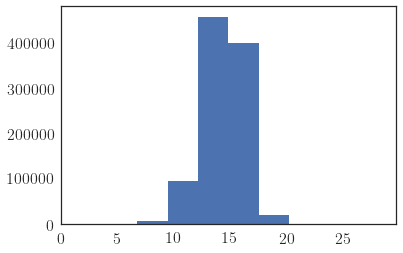

In [134]:
plt.hist(simdf['comb_mJ'][simdf['comb_mJ'].notnull()])

- Calculate inferred values. These are the parameters we normally calculate from observations:
    - inferred trigonometric distances: from observed parallaxes.
    - inferred absolute magnitudes:
        - from inferred distances and apparent magnitudes, and 
        - from empirical relations and observed spectral types
    - inferred spectrophotometric distances (for objects without parallax): from inferred absolute magnitudes and apparent magnitudes

In [153]:
t0 = time.time()
print('calculating inferred trigonometric distance...')
simdf['obs_dist_plx'] = 1000/simdf['obs_plx']
print(time.time()-t0)
print('calculating inferred absolute magnitudes from observed parallaxes...')
simdf['obsMJ_plx'] = simdf['obs_comb_mJ'] - 5*np.log10(simdf['obs_dist_plx']/10.)
simdf['obsMH_plx'] = simdf['obs_comb_mH'] - 5*np.log10(simdf['obs_dist_plx']/10.)
simdf['obsMK_plx'] = simdf['obs_comb_mK'] - 5*np.log10(simdf['obs_dist_plx']/10.)
print(time.time()-t0)
print('calculating inferred absolute magnitudes from empirical relations...')
tqdm.pandas(tqdm())
simdf['obsMJ_phot'] = simdf['obs_sptn'].map(lambda x: empirical.typeToMag(x, '2MASS J', ref='Dupuy')[0])
tqdm.pandas(tqdm())
simdf['obsMH_phot'] = simdf['obs_sptn'].map(lambda x: empirical.typeToMag(x, '2MASS H', ref='Dupuy')[0])
tqdm.pandas(tqdm())
simdf['obsMK_phot'] = simdf['obs_sptn'].map(lambda x: empirical.typeToMag(x, '2MASS KS', ref='Dupuy')[0])
print(time.time()-t0)
print('calculating inferred spectrophotometric distances...')
simdf['obs_Jdist_phot'] = 10.**(1+0.2*(simdf['obs_comb_mJ'] - simdf['obsMJ_phot']))
simdf['obs_Hdist_phot'] = 10.**(1+0.2*(simdf['obs_comb_mH'] - simdf['obsMH_phot']))
simdf['obs_Kdist_phot'] = 10.**(1+0.2*(simdf['obs_comb_mK'] - simdf['obsMK_phot']))
simdf['obs_NIRdist'] = (simdf['obs_Jdist_phot']+simdf['obs_Jdist_phot']+simdf['obs_Jdist_phot'])/3
print(time.time()-t0)  #27.15128803253174 for N=1000, 58111.60655832291 for N=1000000
print('done!')

calculating inferred trigonometric distance...
0.08385801315307617
calculating inferred absolute magnitudes from observed parallaxes...












0it [00:00, ?it/s]

0.30882716178894043
calculating inferred absolute magnitudes from empirical relations...













0it [00:00, ?it/s]











0it [00:00, ?it/s]

22333.468779087067
calculating inferred spectrophotometric distances...
22333.783411979675
done!


In [154]:
simdf.to_csv(path+'LFsim_step3_N1000000.csv',index=False)

In [155]:
simdf.shape

(1000000, 50)

#### Selection Function

Objects selected by distance cut

In [27]:
simdf = pd.read_csv(path+'LFsim_step3_N1000000.csv')

In [28]:
simdf.shape

(1000000, 50)

Text(0,0.5,'Observed NIR distance')

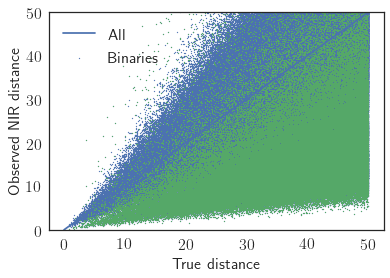

In [29]:
plt.scatter(simdf['true_dist'],simdf['obs_NIRdist'],marker='o',s=1)
plt.scatter(simdf['true_dist'][simdf['binary_flag'] == 1],simdf['obs_NIRdist'][simdf['binary_flag'] == 1],marker='*',s=1)
plt.plot([0,50],[0,50])
plt.ylim(0,50)
plt.legend(['All','Binaries'],fontsize=16)
plt.xlabel('True distance',fontsize=16)
plt.ylabel('Observed NIR distance',fontsize=16)

Text(0,0.5,'Observed NIR distance')

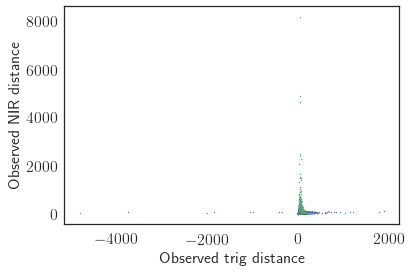

In [30]:
plt.scatter(simdf['obs_dist_plx'],simdf['obs_NIRdist'],marker='o',s=1)
plt.scatter(simdf['obs_dist_plx'][simdf['binary_flag'] == 1],simdf['obs_NIRdist'][simdf['binary_flag'] == 1],marker='*',s=1)
plt.plot([0,50],[0,50])
plt.xlabel('Observed trig distance',fontsize=16)
plt.ylabel('Observed NIR distance',fontsize=16)


Text(0,0.5,'NIR Distance (pc)')

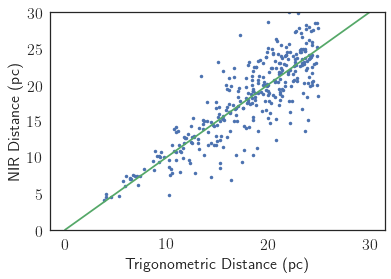

In [31]:
plt.plot(sample['TRIGdist'],sample['NIRdist'],'.')
plt.plot([0,30],[0,30])
plt.ylim(0,30)
plt.xlabel('Trigonometric Distance (pc)',fontsize=16)
plt.ylabel('NIR Distance (pc)',fontsize=16)

Is true_MJ always fainter than combMJ? (i.e. positive difference)

In [32]:
(simdf['true_MJ'] - simdf['combMJ'] < 0).sum()/10**6

0.00732

No. Are these cases where scatter explains the difference?

In [33]:
simdf[['true_sptn','spt2','true_MJ','MJ2','combMJ']][simdf['true_MJ'] - simdf['combMJ'] < 0]

,true_sptn,spt2,true_MJ,MJ2,combMJ
39,21.714982,21.533157,12.031565,11.742920,13.433403
59,19.882376,19.760561,12.127625,11.771873,14.560360
64,20.093207,20.851190,11.603113,11.223890,14.912842
68,16.780125,16.174495,10.491866,10.175203,12.214714
74,25.473218,25.551521,13.614824,13.475791,14.081263
90,24.756867,25.684211,13.932169,13.635897,15.412425
154,20.539702,20.474427,11.834316,11.630686,12.612144
181,25.567277,25.980497,13.764204,13.752408,13.796861
184,20.446691,19.985819,11.634792,11.409570,12.540396
194,16.680806,16.153181,10.088087,10.068930,10.141634


Yes. OK.

In [34]:
simdf[['combMJ','MJ2','true_MJ']]

,combMJ,MJ2,true_MJ
0,9.953545,11.792536,11.073661
1,11.130378,15.751001,13.276187
2,11.156442,15.956528,13.350677
3,10.325926,11.370372,11.016476
4,7.839762,16.832128,10.851584
5,8.033296,16.376178,10.946968
6,9.877318,15.361087,12.242618
7,9.638235,15.352773,12.056956
8,10.846500,16.056833,13.145791
9,8.578242,14.623005,11.070032


In [37]:
#simdf['distbins'] = pd.cut()
#df = pd.DataFrame(index=np.arange(7),columns=['cutoff','Nbf','cumNbf'])
#df['cutoff'] = np.arange(0,35,5)
#df['Nbf'] = simdf.groupby('distbins').size().values
#df['cumNbf'] = np.cumsum(bonafide.groupby('distbins').size().values)
#df

In [41]:
simdf['selected_intrinsic'] = (simdf['true_dist'] <= dlim)# & (simdf['true_sptn'] >= 17) & (simdf['true_sptn'] <= 25)
simdf['selected_obs_plx'] = (simdf['obs_dist_plx'] <= dlim)# & (simdf['obs_sptn'] >= 17) & (simdf['obs_sptn'] <= 25)
simdf['selected_obs_phot'] = (simdf['obs_NIRdist'] <= dlim)# & (simdf['obs_sptn'] >= 17) & (simdf['obs_sptn'] <= 25)

In [42]:
simdf['selected_intrinsic'].sum(),simdf['selected_obs_plx'].sum(),simdf['selected_obs_phot'].sum()

(125098, 138191, 260511)

Objects selected by spectral type

In [43]:
simdf['true_sptn'].max(),simdf['true_sptn'].min(), simdf['true_MJ'].max(), simdf['true_MJ'].min(), \
simdf['obsMJ_plx'].max(), simdf['obsMJ_plx'].min(), simdf['obsMJ_phot'].max(), simdf['obsMJ_phot'].min(),

(26.99999926364785,
 15.000002694798185,
 15.900489007617152,
 7.647719085718888,
 25.41867534688715,
 0.2211050194677817,
 14.762435293832292,
 10.02118056371067)

In [44]:
np.nanmin(simdf['obsMJ_plx']),np.nanmax(simdf['obsMJ_plx']),np.nanmin(simdf['obsMJ_phot']),np.nanmax(simdf['obsMJ_phot']),

(0.2211050194677817, 25.41867534688715, 10.02118056371067, 14.762435293832292)

In [45]:
simdf['true_sptn_bins'] = pd.cut(simdf['true_sptn'],bins=np.arange(15,27.5,0.5),labels=np.arange(15,27,0.5))
simdf['obs_sptn_bins'] = pd.cut(simdf['obs_sptn'],bins=np.arange(15,27.5,0.5),labels=np.arange(15,27,0.5))
simdf['true_MJ_bins'] = pd.cut(simdf['true_MJ'],bins=np.arange(8.25,16.75,0.5),labels=np.arange(8.25,16.25,0.5))
simdf['obs_MJplx_bins'] = pd.cut(simdf['obsMJ_plx'],bins=np.arange(8.25,16.75,0.5),labels=np.arange(8.25,16.25,0.5))
simdf['obs_MJphot_bins'] = pd.cut(simdf['obsMJ_phot'],bins=np.arange(8.25,16.75,0.5),labels=np.arange(8.25,16.25,0.5))

We have simulated a population of ultracool dwarfs resembling our observed one. Now we're going to do a selection similar to the one we did to delimit our sample, in order to quantify contamination and completeness.

#### Selection Function with respect to spectral types

In [46]:
simdf['true_sptn_bins'].unique()

[16.5, 24.5, 21.5, 17.5, 17.0, ..., 15.5, 16.0, 18.0, 22.5, 26.0]
Length: 24
Categories (24, float64): [15.0 < 15.5 < 16.0 < 16.5 ... 25.0 < 25.5 < 26.0 < 26.5]

In [47]:
simdf['obs_sptn_bins'].unique()

[17.0, 25.0, 20.5, 21.5, 20.0, ..., 26.0, 22.5, 19.5, 24.5, 25.5]
Length: 25
Categories (24, float64): [15.0 < 15.5 < 16.0 < 16.5 ... 25.0 < 25.5 < 26.0 < 26.5]

# SELECTION FUNCTION

## By spectral subtype

Goal: obtain the selection function for trigonometric and spectrophotometric distance cuts

First we select the sources that are intrinsically part of the 25pc sample by subtype. Then we select the sources within each subtype bin which are selected by their observed spectral type, and observed distance, be it trigonometric or spectrophotometric.

Steps:
    1. Nobj: Divide the simulated sample by true spectral subtype and count the number of sources per subtype.
    2. Ntrue_sel: Count how many sources per subtype are intrinsically selected by true dist <= 25pc
    3. Nobs_sel: In each subtype bin of intrinsically selected sources, count how many are selected by their observed spectral type. These are the 1-to-1 matches. 
       Objects whose observed spectral type is different from their true spectral type won't be selected.
    4. selected_obs_plx: Number of intrinsically selected sources per subtype that are also selected by their observed subtype and observed trigonometric distance.
    5. SFplx: Proportion of objects selected by their (a) observed trigonometric distance and (b) observed spectral subtype with respect to their corresponding
       true distance and true subtype
    6. selected_obs_phot: Number of intrinsically selected sources per subtype that are also selected by their observed spectrophotometric distance.
    7. SFphot: Proportion of objects selected by their (a) observed spectrometric distance and (b) observed spectral subtype with respect to their corresponding
       true distance and true subtype

In [48]:
sfspt = pd.DataFrame(index=np.arange(15,27,0.5),columns=['sptn','Nobj','Ntrue_sel','selected_obs_plx','selected_obs_phot','SFplx','SFphot']) #'Nobs_sel',
sfspt['sptn'] = np.arange(15,27,0.5)
sfspt['Nobj'] = simdf.groupby('true_sptn_bins').size().values  #samp
sfspt['Ntrue_sel'] = simdf[simdf['selected_intrinsic'] == True].groupby('true_sptn_bins').size().values #true

## 1. divide sample by true subtypes
## 2. for each subtype, pick out the intrinsically selected by true distance
## 3. divide those by observed subtype
## 4. count how many there are in each subtype
## These are the sources by their observed subtype which are indeed part of the intrinsic selected sample

obssel = pd.DataFrame(index=np.arange(15,27,0.5), columns=np.arange(15,27,0.5))
plxsubdf = pd.DataFrame(index=np.arange(15,27,0.5), columns=np.arange(15,27,0.5))
photsubdf = pd.DataFrame(index=np.arange(15,27,0.5), columns=np.arange(15,27,0.5))

for x in sfspt['sptn']:
    subdf = simdf.groupby('true_sptn_bins').get_group(sfspt['sptn'][x])
    obssel.loc[x] = subdf.groupby('obs_sptn_bins').size().values
    plxsubdf.loc[x] = subdf[(subdf['selected_intrinsic'] == True) & (subdf['selected_obs_plx'] == True)].groupby('obs_sptn_bins').size().values
    photsubdf.loc[x] = subdf[(subdf['selected_intrinsic'] == True) & (subdf['selected_obs_phot'] == True)].groupby('obs_sptn_bins').size().values

#obssel = pd.DataFrame(index=np.arange(15,27,0.5), columns=np.arange(15,27,0.5), 
#                  data=[simdf.groupby('true_sptn_bins').get_group(sfspt['sptn'][x])[simdf['selected_intrinsic'] == True].groupby('obs_sptn_bins').size().values for x in sfspt['sptn']])

## Diagonals have the number of coincident observed and true subtypes in the intrinsic selected sample
#sfspt['Nobs_sel'] = np.diag(obssel)
sfspt['selected_obs_plx'] = np.diag(plxsubdf)
sfspt['selected_obs_phot'] = np.diag(photsubdf)#simdf[simdf['selected_obs_phot'] == True].groupby('obs_sptn_bins').size().values
sfspt['SFplx'] = sfspt['selected_obs_plx']/sfspt['Ntrue_sel']  #sf = selected fraction
sfspt['SFphot'] = sfspt['selected_obs_phot']/sfspt['Ntrue_sel']

sfspt.to_csv(path+"SFspt.csv",index=False)

In [49]:
path+"SFspt.csv"

'/Users/daniella/Research/M7L5Sample/LFsimulation/SFspt.csv'

selected_obs_phot: trickling in more objects than trickling out from large uncertainties in NIR distance

In [50]:
sfspt

,sptn,Nobj,Ntrue_sel,selected_obs_plx,selected_obs_phot,SFplx,SFphot
15.0,15.0,41783,5301,1049,0,0.197887,0.000000
15.5,15.5,41520,5168,973,0,0.188274,0.000000
16.0,16.0,41519,5163,957,957,0.185357,0.185357
16.5,16.5,42139,5271,989,858,0.187630,0.162777
17.0,17.0,41359,5023,984,981,0.195899,0.195302
17.5,17.5,41684,5209,962,884,0.184680,0.169706
18.0,18.0,41365,5327,1070,1047,0.200864,0.196546
18.5,18.5,41803,5282,1000,904,0.189322,0.171147
19.0,19.0,41637,5186,1043,1043,0.201118,0.201118
19.5,19.5,41456,5142,1006,946,0.195644,0.183975


In [51]:
sfspt['SFplx'] = np.round(sfspt['SFplx'],2)
sfspt['SFphot'] = np.round(sfspt['SFphot'],2)
sfspt['sptn'] = sfspt['sptn'].map(lambda x: splat.typeToNum(x))

In [52]:
sfspt.to_latex('sfspt.tex',index=False)

In [53]:
pwd

'/Users/daniella/Research/M7L5Sample'

In [54]:
(5258*50**3/41750)**(1/3)

25.06251817946606

0.11464611744392396


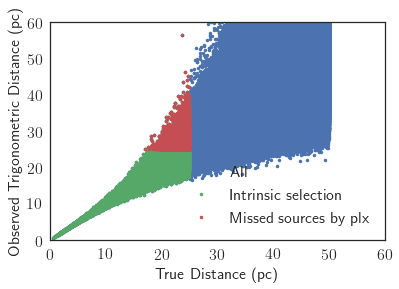

In [55]:
tn = simdf[(simdf['selected_obs_plx'] == False) & (simdf['selected_intrinsic'] == True)].index
tt = simdf[(simdf['selected_intrinsic'] == True)].index
obs = simdf[(simdf['selected_obs_plx'] == True)].index
plt.plot(simdf['true_dist'], simdf['obs_dist_plx'], '.')
plt.plot(simdf.loc[tt,'true_dist'], simdf.loc[tt,'obs_dist_plx'], '.')
plt.plot(simdf.loc[tn,'true_dist'], simdf.loc[tn,'obs_dist_plx'], '.')
#plt.plot(simdf.loc[obs,'true_dist'], simdf.loc[obs,'obs_dist_plx'], '.')
plt.xlabel('True Distance (pc)',fontsize=16)
plt.ylabel('Observed Trigonometric Distance (pc)',fontsize=16)
plt.legend(['All','Intrinsic selection','Missed sources by plx'],fontsize=16)
plt.ylim(0,60)
plt.xlim(0,60)
print(len(tn)/(len(tt)))

Just as many binaries in true negatives as in the full sample

In [56]:
simdf.loc[tn][simdf['binary_flag'] == 1].shape, len(tn), 2877/14342

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


((2877, 50), 14342, 0.2005996374285316)

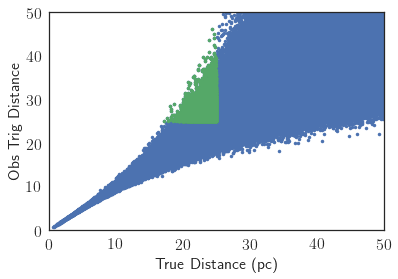

In [57]:
plt.plot(simdf['true_dist'],simdf['obs_dist_plx'],'.')
plt.plot(simdf.loc[tn,'true_dist'],simdf.loc[tn,'obs_dist_plx'],'.')
plt.xlabel('True Distance (pc)',fontsize=16)
plt.ylabel('Obs Trig Distance',fontsize=16)
plt.xlim(0,50)
plt.ylim(0,50)
print()

True negatives don't occur because of the error added to the true parallax

Text(0.5,0,'Observed Trig  - True')

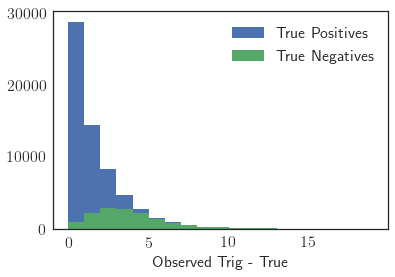

In [58]:
plt.hist(simdf.loc[tt,'obs_dist_plx'] - simdf.loc[tt,'true_dist'],bins=np.arange(0,20,1))
plt.hist(simdf.loc[tn,'obs_dist_plx'] - simdf.loc[tn,'true_dist'],bins=np.arange(0,20,1))
plt.legend(['True Positives','True Negatives'],fontsize=16)
plt.xlabel('Observed Trig  - True',fontsize=16)

In [59]:
simdf[simdf['obs_dist_plx'] < 0]

,true_dist,true_sptn,true_plx,rel_MJ,rel_MH,rel_MK,true_MJ,true_MH,true_MK,age,q,mass1,mass2,teff2,spt2,MJ2,MH2,MK2,binary_flag,combMJ,combMH,combMK,teff1,obs_sptn,comb_mJ,comb_mH,comb_mK,obs_comb_mJ,obs_comb_mH,obs_comb_mK,obs_plx,obs_dist_plx,obsMJ_plx,obsMH_plx,obsMK_plx,obsMJ_phot,obsMH_phot,obsMK_phot,obs_Jdist_phot,obs_Hdist_phot,obs_Kdist_phot,obs_NIRdist,selected_intrinsic,selected_obs_plx,selected_obs_phot,true_sptn_bins,obs_sptn_bins,true_MJ_bins,obs_MJplx_bins,obs_MJphot_bins
104877,48.161296,26.051299,20.763561,13.939548,12.832851,12.168671,14.264727,12.286154,12.486599,7.925421,0.870458,0.076373,0.06648,974.318027,35.681485,15.188007,15.431703,14.355481,1.0,12.962151,9.912525,10.597975,1523.507259,25.450166,16.375642,13.326016,14.011466,16.413027,13.284433,13.978711,-0.207365,-4822.420168,NaN,NaN,NaN,13.737035,12.650802,12.032293,34.292443,13.388328,24.506636,34.292443,False,True,False,26.0,25.0,14.25,NaN,13.25
298691,47.094735,24.295910,21.233796,13.149549,12.132533,11.641754,13.356559,12.108762,11.610080,6.397046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,13.356559,12.108762,11.610080,NaN,23.293025,16.721421,15.473624,14.974942,16.723681,15.453040,14.943888,-0.266340,-3754.598160,NaN,NaN,NaN,12.852359,11.874533,11.435777,59.465416,51.963858,50.306267,59.465416,False,True,False,24.0,23.0,13.25,NaN,12.75
303694,49.197384,15.858163,20.326284,10.021179,9.464701,9.387741,9.655668,9.408395,9.490572,9.023188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,9.655668,9.408395,9.490572,NaN,15.178433,13.115378,12.868105,12.950282,13.137975,12.874833,12.895147,-0.480518,-2081.085682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,False,15.5,15.0,9.25,NaN,NaN
361669,49.853179,20.948350,20.058901,11.953508,11.115210,10.718444,12.083721,11.455281,10.680964,6.346963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,12.083721,11.455281,10.680964,NaN,21.418690,15.572185,14.943745,14.169428,15.484826,14.895192,14.187593,-2.388142,-418.735604,NaN,NaN,NaN,12.104844,11.240153,10.852780,47.423795,53.827954,46.447522,47.423795,False,True,False,20.5,21.0,11.75,NaN,11.75
476941,49.988706,24.388882,20.004519,13.149549,12.132533,11.641754,13.266920,11.740330,11.578427,3.765192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,13.266920,11.740330,11.578427,NaN,25.203385,16.761279,15.234690,15.072787,16.732772,15.143710,15.025880,-0.495457,-2018.337899,NaN,NaN,NaN,13.641556,12.565710,11.969003,41.518639,32.779326,40.867238,41.518639,False,True,False,24.0,25.0,13.25,NaN,13.25
662465,47.036558,22.632986,21.260059,12.730065,11.769185,11.347750,13.067136,11.849709,11.719974,0.527661,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,13.067136,11.849709,11.719974,NaN,22.000628,16.429314,15.211887,15.082151,16.322014,15.191808,14.979033,-0.537461,-1860.600959,NaN,NaN,NaN,12.326061,11.425220,11.038005,62.978260,56.665337,61.405264,62.978260,False,True,False,22.5,22.0,12.75,NaN,12.25
798305,49.110807,18.342750,20.362117,10.988594,10.339530,9.807434,11.164289,9.942289,9.161764,2.597547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,11.164289,9.942289,9.161764,NaN,18.051245,14.620175,13.398175,12.617649,14.622325,13.349906,12.552318,-2.774376,-360.441427,NaN,NaN,NaN,11.006112,10.354021,9.821058,52.874044,39.735356,35.176455,52.874044,False,True,False,18.0,18.0,10.75,NaN,10.75
932685,49.608486,22.014370,20.157841,12.325816,11.425014,11.037807,11.944520,10.864720,10.791787,2.254941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,11.944520,10.864720,10.791787,NaN,21.368030,15.422300,14.342500,14.269567,15.411371,14.406689,14.247985,-0.932624,-1072.243575,NaN,NaN,NaN,12.086175,11.224662,10.836555,46.242271,43.291783,48.115607,46.242271,False,True,False,22.0,21.0,11.75,NaN,11.75
966058,46.655769,26.069730,21.433577,13.939548,12.832851,12.168671,13.738887,13.006154,12.070446,7.009578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,13.738887,13.006154,12.070446,NaN,24.585426,17.083413,16.350681,15.414973,17.135937,16.316858,15.488051,-0.994882,-1005.144278,NaN,NaN,NaN,13.393060,12.345930,11.804786,56.049982,62.256626,54.532213,56.049982,False,True,Fal

In [60]:
(simdf.loc[tn,'obs_dist_plx'] - simdf.loc[tn,'true_dist']).max(),(simdf.loc[tn,'obs_dist_plx'] - simdf.loc[tn,'true_dist']).min()

(32.91413435382627, 0.015398076923528237)

## By absolute magnitude bin

In [61]:
sfmag = pd.DataFrame(index=np.arange(8.25,16.25,0.5),columns=['MJ','Nobj','Ntrue_sel','Nsel_plx','Nsel_phot','selected_obs_plx','selected_obs_phot','SFplx','SFphot'])
sfmag['MJ'] = np.arange(8.25,16.25,0.5)
sfmag['Nobj'] = simdf.groupby('true_MJ_bins').size().values  #samp
sfmag['Ntrue_sel'] = simdf[simdf['selected_intrinsic'] == True].groupby('true_MJ_bins').size().values  #true
## 1. divide sample by true absolute magnitude bins
## 2. for each absolute magnitude bin, pick out the intrinsically selected by true distance
## 3. divide those by observed absolute magnitude 
## 4. count how many there are in each absolute magnitude 
## These are the sources by their observed absolute magnitude  which are indeed part of the intrinsic selected sample

obsselplxdf = pd.DataFrame(index=np.arange(8.25,16.25,0.5), columns=np.arange(8.25,16.25,0.5))
obsselphotdf = pd.DataFrame(index=np.arange(8.25,16.25,0.5), columns=np.arange(8.25,16.25,0.5))
plxsubdf = pd.DataFrame(index=np.arange(8.25,16.25,0.5), columns=np.arange(8.25,16.25,0.5))
photsubdf = pd.DataFrame(index=np.arange(8.25,16.25,0.5), columns=np.arange(8.25,16.25,0.5))

for x in sfmag['MJ']:
    subdf = simdf.groupby('true_MJ_bins').get_group(sfmag['MJ'][x])
    obsselplxdf.loc[x] =  subdf.groupby('obs_MJplx_bins').size().values
    obsselphotdf.loc[x] = subdf.groupby('obs_MJphot_bins').size().values
    plxsubdf.loc[x] = subdf[(subdf['selected_intrinsic'] == True) & (subdf['selected_obs_plx'] == True)].groupby('obs_MJplx_bins').size().values
    photsubdf.loc[x] = subdf[(subdf['selected_intrinsic'] == True) & (subdf['selected_obs_phot'] == True)].groupby('obs_MJphot_bins').size().values

## Diagonals have the number of coincident observed and true subtypes in the intrinsic selected sample
sfmag['Nsel_plx'] = np.diag(obsselplxdf)
sfmag['Nsel_phot'] = np.diag(obsselphotdf)
sfmag['selected_obs_plx'] = np.diag(plxsubdf)
sfmag['SFplx'] = sfmag['selected_obs_plx']/sfmag['Ntrue_sel']  #sf = selected fraction
sfmag['selected_obs_phot'] = np.diag(photsubdf) #simdf[simdf['selected_obs_phot'] == True].groupby('obs_sptn_bins').size().values
sfmag['SFphot'] = sfmag['selected_obs_phot']/sfmag['Ntrue_sel']
sfmag.to_csv(path+"SFmag.csv",index=False)

In [62]:
pwd

'/Users/daniella/Research/M7L5Sample'

In [63]:
sfmag

,MJ,Nobj,Ntrue_sel,Nsel_plx,Nsel_phot,selected_obs_plx,selected_obs_phot,SFplx,SFphot
8.25,8.25,1797,240,624,0,111,0,0.462500,0.000000
8.75,8.75,13888,1758,4976,0,849,0,0.482935,0.000000
9.25,9.25,39368,4891,14115,0,2423,0,0.495400,0.000000
9.75,9.75,64752,8045,23419,7784,4006,858,0.497949,0.106650
10.25,10.25,87827,10953,31770,25809,5447,2976,0.497307,0.271706
10.75,10.75,113026,14038,41115,42382,7127,4701,0.507693,0.334877
11.25,11.25,124787,15911,45553,48831,7950,5636,0.499654,0.354220
11.75,11.75,117226,14525,42537,41366,7336,4685,0.505060,0.322547
12.25,12.25,106169,13246,38716,35255,6699,4014,0.505738,0.303035
12.75,12.75,101778,12683,36745,33182,6376,3815,0.502720,0.300796


In [64]:
sfmag['SFplx'] = np.round(sfmag['SFplx'],2)
sfmag['SFphot'] = np.round(sfmag['SFphot'],2)

In [65]:
sfmag.columns

Index(['MJ', 'Nobj', 'Ntrue_sel', 'Nsel_plx', 'Nsel_phot', 'selected_obs_plx',
       'selected_obs_phot', 'SFplx', 'SFphot'],
      dtype='object')

In [66]:
sfmag[['MJ', 'Nobj', 'Ntrue_sel', 'selected_obs_plx', 'selected_obs_phot', 'SFplx', 'SFphot']].to_latex('sfmag.tex',index=False)

In [67]:
pwd

'/Users/daniella/Research/M7L5Sample'

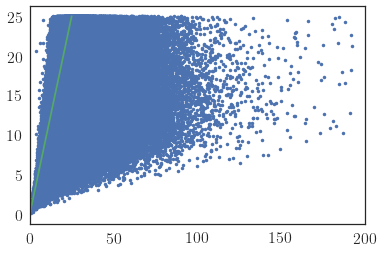

In [68]:
plt.plot(simdf['obs_dist_plx'][simdf['selected_obs_phot'] == True],simdf['obs_NIRdist'][simdf['selected_obs_phot'] == True],'.')
plt.xlim(0,200)
plt.plot([0,25],[0,25])

### plot selected_obs_phot trig vs nir, see whats different about them. see if difference between the distances is larger than the scatter
### check how many are binaries: see if BF is larger than the overall BF

# FALSE POSITIVES

## By spectral subtype

In [71]:
sfspt['sptn'] = sfspt['sptn'].map(lambda x: splat.typeToNum(x))

In [72]:
fpspt = pd.DataFrame(index=np.arange(15,27,0.5),columns=['sptn','Nobj','Ntrue_nosel','selected_obs_plx','selected_obs_phot','%sel_plx','%sel_phot'])

fpspt['sptn'] = np.arange(15,27,0.5)
fpspt['Nobj'] = simdf.groupby('true_sptn_bins').size().values  #samp
fpspt['Ntrue_nosel'] = simdf[simdf['selected_intrinsic'] == False].groupby('true_sptn_bins').size()

obsnosel = pd.DataFrame(index=np.arange(15,27,0.5), columns=np.arange(15,27,0.5))
plxsubdf = pd.DataFrame(index=np.arange(15,27,0.5), columns=np.arange(15,27,0.5))
photsubdf = pd.DataFrame(index=np.arange(15,27,0.5), columns=np.arange(15,27,0.5))

for x in fpspt['sptn']:
    subdf = simdf.groupby('true_sptn_bins').get_group(sfspt['sptn'][x])
    obsnosel.loc[x] = subdf[subdf['selected_intrinsic'] == False].groupby('obs_sptn_bins').size().values
    plxsubdf.loc[x] = subdf[(subdf['selected_intrinsic'] == False) & (subdf['selected_obs_plx'] == True)].groupby('obs_sptn_bins').size().values
    photsubdf.loc[x] = subdf[(subdf['selected_intrinsic'] == False) & (subdf['selected_obs_phot'] == True)].groupby('obs_sptn_bins').size().values
    
#fpspt['Nobs_nosel'] = np.diag(obsnosel)

fpspt['selected_obs_plx'] = np.diag(plxsubdf)
fpspt['selected_obs_phot'] = np.diag(photsubdf)
fpspt['%sel_plx'] = fpspt['selected_obs_plx']/fpspt['Ntrue_nosel']*(dsim/dlim)**3
fpspt['%sel_phot'] = fpspt['selected_obs_phot']/fpspt['Ntrue_nosel']*(dsim/dlim)**3
fpspt.to_csv(path+"FPspt.csv",index=False)

In [73]:
fpspt_plx = plxsubdf/fpspt['Ntrue_nosel']*(dsim/dlim)**3
fpspt_phot = photsubdf/fpspt['Ntrue_nosel']*(dsim/dlim)**3

In [74]:
fpspt

,sptn,Nobj,Ntrue_nosel,selected_obs_plx,selected_obs_phot,%sel_plx,%sel_phot
15.0,15.0,41783,36482,245,0,0.053725,0.000000
15.5,15.5,41520,36352,231,0,0.050836,0.000000
16.0,16.0,41519,36356,231,1591,0.050831,0.350094
16.5,16.5,42139,36868,272,1280,0.059021,0.277748
17.0,17.0,41359,36336,279,1692,0.061427,0.372523
17.5,17.5,41684,36475,269,1453,0.058999,0.318684
18.0,18.0,41365,36038,261,1758,0.057939,0.390255
18.5,18.5,41803,36521,229,1450,0.050163,0.317625
19.0,19.0,41637,36451,254,1660,0.055746,0.364325
19.5,19.5,41456,36314,232,1448,0.051110,0.318995


In [75]:
fpspt['%sel_plx'] = fpspt['%sel_plx'].round(2)
fpspt['%sel_phot'] = fpspt['%sel_phot'].round(2)
fpspt.to_latex('fpspt.tex',index=False)

## By absolute magnitude bin

In [76]:
fpmag = pd.DataFrame(index=np.arange(8.25,16.25,0.5),columns=['MJ','Nobj','Ntrue_nosel','Nobs_nosel_plx','Nobs_nosel_phot','selected_obs_plx','selected_obs_phot','%sel_plx','%sel_phot'])

fpmag['MJ'] = np.arange(8.25,16.25,0.5)
fpmag['Nobj'] = simdf.groupby('true_MJ_bins').size().values  #samp
fpmag['Ntrue_nosel'] = simdf[simdf['selected_intrinsic'] == False].groupby('true_MJ_bins').size()

obsnoselplxdf = pd.DataFrame(index=np.arange(8.25,16.25,0.5), columns=np.arange(8.25,16.25,0.5))
obsnoselphotdf = pd.DataFrame(index=np.arange(8.25,16.25,0.5), columns=np.arange(8.25,16.25,0.5))
plxsubdf = pd.DataFrame(index=np.arange(8.25,16.25,0.5), columns=np.arange(8.25,16.25,0.5))
photsubdf = pd.DataFrame(index=np.arange(8.25,16.25,0.5), columns=np.arange(8.25,16.25,0.5))

for x in fpmag['MJ']:
    subdf = simdf.groupby('true_MJ_bins').get_group(sfmag['MJ'][x])
    obsnoselplxdf.loc[x] = subdf[subdf['selected_intrinsic'] == False].groupby('obs_MJplx_bins').size().values
    obsnoselphotdf.loc[x] = subdf[subdf['selected_intrinsic'] == False].groupby('obs_MJphot_bins').size().values
    plxsubdf.loc[x] = subdf[(subdf['selected_intrinsic'] == False) & (subdf['selected_obs_plx'] == True)].groupby('obs_MJplx_bins').size().values
    photsubdf.loc[x] = subdf[(subdf['selected_intrinsic'] == False) & (subdf['selected_obs_phot'] == True)].groupby('obs_MJphot_bins').size().values
    
fpmag['Nobs_nosel_plx'] = np.diag(obsnoselplxdf)
fpmag['Nobs_nosel_phot'] = np.diag(obsnoselphotdf)
fpmag['selected_obs_plx'] = np.diag(plxsubdf)
fpmag['selected_obs_phot'] = np.diag(photsubdf)
fpmag['%sel_plx'] = fpmag['selected_obs_plx']/fpmag['Ntrue_nosel']*(dsim/dlim)**3
fpmag['%sel_phot'] = fpmag['selected_obs_phot']/fpmag['Ntrue_nosel']*(dsim/dlim)**3
fpmag.to_csv(path+"FPmag.csv",index=False)

In [77]:
fpmag

,MJ,Nobj,Ntrue_nosel,Nobs_nosel_plx,Nobs_nosel_phot,selected_obs_plx,selected_obs_phot,%sel_plx,%sel_phot
8.25,8.25,1797,1557,507,0,9,0,0.046243,0.000000
8.75,8.75,13888,12130,4032,0,69,0,0.045507,0.000000
9.25,9.25,39368,34477,11478,0,222,0,0.051513,0.000000
9.75,9.75,64752,56707,19099,6838,375,1106,0.052904,0.156030
10.25,10.25,87827,76874,25889,22501,562,3603,0.058485,0.374951
10.75,10.75,113026,98988,33475,37205,667,6366,0.053906,0.514487
11.25,11.25,124787,108876,37020,42596,867,7326,0.063705,0.538300
11.75,11.75,117226,102701,34674,36205,807,6574,0.062862,0.512088
12.25,12.25,106169,92923,31524,30836,731,5636,0.062934,0.485219
12.75,12.75,101778,89095,29906,28982,726,5259,0.065189,0.472215


In [78]:
fpmag['%sel_plx'] = fpmag['%sel_plx'].round(2)
fpmag['%sel_phot'] = fpmag['%sel_phot'].round(2)
fpmag.to_latex('fpmag.tex',index=False)

#### Luminosity Function

Correct number of objects per spectral type bin according to their selection function

In [79]:
simdf.columns

Index(['true_dist', 'true_sptn', 'true_plx', 'rel_MJ', 'rel_MH', 'rel_MK',
       'true_MJ', 'true_MH', 'true_MK', 'age', 'q', 'mass1', 'mass2', 'teff2',
       'spt2', 'MJ2', 'MH2', 'MK2', 'binary_flag', 'combMJ', 'combMH',
       'combMK', 'teff1', 'obs_sptn', 'comb_mJ', 'comb_mH', 'comb_mK',
       'obs_comb_mJ', 'obs_comb_mH', 'obs_comb_mK', 'obs_plx', 'obs_dist_plx',
       'obsMJ_plx', 'obsMH_plx', 'obsMK_plx', 'obsMJ_phot', 'obsMH_phot',
       'obsMK_phot', 'obs_Jdist_phot', 'obs_Hdist_phot', 'obs_Kdist_phot',
       'obs_NIRdist', 'selected_intrinsic', 'selected_obs_plx',
       'selected_obs_phot', 'true_sptn_bins', 'obs_sptn_bins', 'true_MJ_bins',
       'obs_MJplx_bins', 'obs_MJphot_bins'],
      dtype='object')

In [80]:
sample.groupby('bestsptn').size()

bestsptn
15.5     2
16.0     2
16.5     5
17.0    47
17.5    30
18.0    60
18.5    20
19.0    42
19.5     9
20.0    15
20.5     8
21.0    24
21.5    12
22.0    23
22.5     8
23.0     9
23.5     5
24.0    17
24.5     7
25.0    19
25.5     2
26.0     1
26.5     1
dtype: int64

In [81]:
sample.groupby('disttag').size()

disttag
WISEplx     11
phot        22
plx        335
dtype: int64

In [82]:
sample['sptn_bins_full'] = pd.cut(sample['bestsptn'],bins=np.arange(14.5,28.5,1),labels=np.arange(15,28,1))

In [83]:
sample.groupby('sptn_bins_full').size()

sptn_bins_full
15     2
16     7
17    77
18    80
19    51
20    23
21    36
22    31
23    14
24    24
25    21
26     2
27     0
dtype: int64

(array([ 9., 77., 80., 51., 23., 59., 17., 22., 26.,  4.]),
 array([15.5, 16.6, 17.7, 18.8, 19.9, 21. , 22.1, 23.2, 24.3, 25.4, 26.5]),
 <a list of 10 Patch objects>)

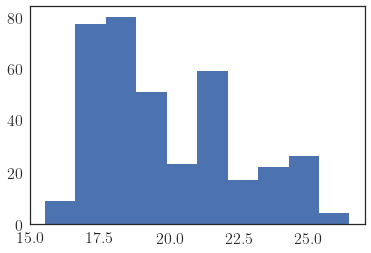

In [84]:
plt.hist(sample['bestsptn'])

In [85]:
sample['STDsptn_bins'] = pd.cut(sample['stdsptn'],bins=np.arange(14.5,28.5,1),labels=np.arange(15,28,1))

In [86]:
sample.groupby('STDsptn_bins').size()

STDsptn_bins
15      0
16      1
17     30
18    103
19     20
20      5
21     56
22     26
23     13
24     13
25     22
26      0
27      0
dtype: int64

(array([  1.,  30., 103.,  20.,   5.,  56.,  26.,  13.,  13.,  22.]),
 array([16. , 16.9, 17.8, 18.7, 19.6, 20.5, 21.4, 22.3, 23.2, 24.1, 25. ]),
 <a list of 10 Patch objects>)

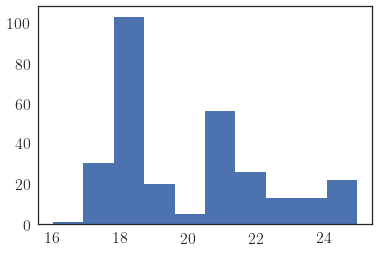

In [87]:
plt.hist(sample['stdsptn'][sample['stdsptn'].notnull()])

In [88]:
sample.groupby('bestsptn').size()

bestsptn
15.5     2
16.0     2
16.5     5
17.0    47
17.5    30
18.0    60
18.5    20
19.0    42
19.5     9
20.0    15
20.5     8
21.0    24
21.5    12
22.0    23
22.5     8
23.0     9
23.5     5
24.0    17
24.5     7
25.0    19
25.5     2
26.0     1
26.5     1
dtype: int64

In [89]:
np.sum(sample.groupby('bestsptn').size().values)

368

In [90]:
sample.groupby('disttag').size()

disttag
WISEplx     11
phot        22
plx        335
dtype: int64

In [91]:
np.sum(sample.groupby('disttag').size().values)

368

In [92]:
df = pd.DataFrame(sample.groupby(['STDsptn_bins','disttag']).size(),columns=['Nobj'])
df

Nobj
STDsptn_bins disttag      
16           plx         1
17           WISEplx     1
             phot        3
             plx        26
18           WISEplx     2
             phot        9
             plx        92
19           plx        20
20           plx         5
21           WISEplx     4
             phot        3
             plx        49
22           phot        2
             plx        24
23           plx        13
24           WISEplx     1
             plx        12
25           plx        22

In [93]:
sample.groupby('STDsptn_bins').size().values

array([  0,   1,  30, 103,  20,   5,  56,  26,  13,  13,  22,   0,   0])

In [94]:
np.arange(17,26,1)

array([17, 18, 19, 20, 21, 22, 23, 24, 25])

In [95]:
sample.groupby('STDsptn_bins').size()

STDsptn_bins
15      0
16      1
17     30
18    103
19     20
20      5
21     56
22     26
23     13
24     13
25     22
26      0
27      0
dtype: int64

In [101]:
lfspt = pd.DataFrame(index=np.arange(17,26,1),columns=['sptn','Nsamp','Nplx','Nphot','sf_plx','sf_phot'])
lfspt['sptn'] = np.arange(17,26,1)
lfspt['Nsamp'] = sample.groupby('STDsptn_bins').size().values[2:11]
lfspt['sf_plx'] = sfspt['SFplx']
lfspt['sf_phot'] = sfspt['SFphot']

print(np.sum(lfspt['Nsamp']))

df = pd.DataFrame(sample.groupby(['STDsptn_bins','disttag']).size(),columns=['Nobj'])
for x in lfspt['sptn']:
    if x < 16:
        lfspt.loc[x,'Nplx'] = 0
        lfspt.loc[x,'Nphot'] = 0
    if x >= 16:
        lfspt.loc[x,'Nplx'] = df['Nobj'][x]['plx']
        if 'phot' in df['Nobj'][x].keys():
            lfspt.loc[x,'Nphot'] = df['Nobj'][x]['phot']
        else:
            lfspt.loc[x,'Nphot'] = 0

lfspt['Ncorr_plx'] = lfspt['Nsamp']/lfspt['sf_plx']
lfspt['Ncorr_phot'] = lfspt['Nsamp']/lfspt['sf_phot']
lfspt['Ncorr_comb'] = (lfspt['Nplx']/lfspt['sf_plx']) + (lfspt['Nphot']/lfspt['sf_phot']) 

vol = [41641.33171558822, 383.3633713007319] #From Areal coverage estimation.ipynb: accessible_vol_avg, accessible_vol_std
#lfspt['plx_dens'] = lfspt['Ncorr_plx']/vol[0]
#lfspt['plx_dens_unc'] = (np.sqrt(lfspt['Ncorr_plx'])*vol[0] - vol[1]*lfspt['Ncorr_plx'])/vol[0]**2
#lfspt['phot_dens'] = lfspt['Ncorr_phot']/vol[0]
#lfspt['phot_dens_unc'] = (np.sqrt(lfspt['Ncorr_phot'])*vol[0] - vol[1]*lfspt['Ncorr_phot'])/vol[0]**2
lfspt['comb_dens'] = lfspt['Ncorr_comb']/vol[0]
lfspt['comb_dens_unc_plus'] = poisson_unc(lfspt['Ncorr_comb'])[0]/vol[0]
lfspt['comb_dens_unc_minus'] = poisson_unc(lfspt['Ncorr_comb'])[1]/vol[0]
lfspt.to_csv(path+"LFspt.csv",index=False)
lfspt

288


,sptn,Nsamp,Nplx,Nphot,sf_plx,sf_phot,Ncorr_plx,Ncorr_phot,Ncorr_comb,comb_dens,comb_dens_unc_plus,comb_dens_unc_minus
17,17,30,26,3,0.20,0.20,150.000000,150.000000,145.000000,0.003482,0.000302,0.000278
18,18,103,92,9,0.20,0.20,515.000000,515.000000,505.000000,0.012127,0.000552,0.000528
19,19,20,20,0,0.20,0.20,100.000000,100.000000,100.000000,0.002401,0.000253,0.000229
20,20,5,5,0,0.20,0.20,25.000000,25.000000,25.000000,0.000600,0.000133,0.000109
21,21,56,49,3,0.19,0.19,294.736842,294.736842,273.684211,0.006572,0.000410,0.000386
22,22,26,24,2,0.20,0.20,130.000000,130.000000,130.000000,0.003122,0.000286,0.000262
23,23,13,13,0,0.19,0.19,68.421053,68.421053,68.421053,0.001643,0.000211,0.000187
24,24,13,12,0,0.20,0.20,65.000000,65.000000,60.000000,0.001441,0.000199,0.000175
25,25,22,22,0,0.19,0.19,115.789474,115.789474,115.789474,0.002781,0.000271,0.000247


# CHECK THAT LFMAG IS DIVIDED OVER MJ FROM PLX AND PHOT

In [102]:
path+"LFspt.csv"

'/Users/daniella/Research/M7L5Sample/LFsimulation/LFspt.csv'

In [116]:
sample['MJ_bins'] = pd.cut(sample['MJ'],bins=np.arange(8.25,16.75,0.5),labels=np.arange(8.25,16.25,0.5))

lfmag = pd.DataFrame(index=np.arange(8.25,16.25,0.5),columns=['MJ','Nsamp','Nplx','Nphot','sf_plx','sf_phot'])
lfmag['MJ'] = np.arange(8.25,16.25,0.5)
lfmag['Nsamp'] = sample.groupby('MJ_bins').size().values
lfmag['sf_plx'] = sfmag['SFplx']
lfmag['sf_phot'] = sfmag['SFphot']

print(np.sum(lfmag['Nsamp']))

df = pd.DataFrame(sample.groupby(['MJ_bins','disttag']).size(),columns=['Nobj'])
for x in lfmag['MJ']:
    if x < 14.5:
        if 'plx' in df['Nobj'][x].keys():
            lfmag.loc[x,'Nplx'] = df['Nobj'][x]['plx']
        else:
            lfmag.loc[x,'Nplx'] = 0
        if 'phot' in df['Nobj'][x].keys():
            lfmag.loc[x,'Nphot'] = df['Nobj'][x]['phot']
        else:
            lfmag.loc[x,'Nphot'] = 0
    else:
        lfmag.loc[x,'Nplx'] = 0
        lfmag.loc[x,'Nphot'] = 0

#lfmag['Ncorr_plx'] = lfmag['Nsamp']/lfmag['sf_plx']
#lfmag['Ncorr_phot'] = lfmag['Nsamp']/lfmag['sf_phot']
lfmag['Ncorr_comb'] = lfmag['Nplx']/lfmag['sf_plx'] + (lfmag['Nphot']/lfmag['sf_phot']) 

vol = 4/3*np.pi*25**3*0.636
vol_unc = 4/3*np.pi*25**3*0.0059
#lfmag['plx_dens'] = lfmag['Ncorr_plx']/vol
#lfmag['phot_dens'] = lfmag['Ncorr_phot']/vol
lfmag['comb_dens'] = lfmag['Ncorr_comb']/vol
lfmag['comb_dens_unc_plus'] = poisson_unc(lfmag['Ncorr_comb'])[0]/vol
lfmag['comb_dens_unc_minus'] = poisson_unc(lfmag['Ncorr_comb'])[1]/vol
lfmag.to_csv(path+"LFmag.csv",index=False)
lfmag

366


,MJ,Nsamp,Nplx,Nphot,sf_plx,sf_phot,Ncorr_comb,comb_dens,comb_dens_unc_plus,comb_dens_unc_minus
8.25,8.25,1,1,0,0.46,0.00,NaN,NaN,NaN,NaN
8.75,8.75,3,3,0,0.48,0.00,NaN,NaN,NaN,NaN
9.25,9.25,7,7,0,0.50,0.00,NaN,NaN,NaN,NaN
9.75,9.75,14,13,0,0.50,0.11,26.000000,0.000625,0.000136,0.000112
10.25,10.25,54,46,7,0.50,0.27,117.925926,0.002833,0.000273,0.000249
10.75,10.75,81,71,8,0.51,0.33,163.458111,0.003927,0.000320,0.000296
11.25,11.25,58,55,1,0.50,0.35,112.857143,0.002711,0.000268,0.000244
11.75,11.75,57,54,2,0.51,0.32,112.132353,0.002694,0.000267,0.000243
12.25,12.25,32,28,2,0.51,0.30,61.568627,0.001479,0.000201,0.000177
12.75,12.75,32,31,1,0.50,0.30,65.333333,0.001570,0.000207,0.000183


In [117]:
vol

41626.10266006476

In [119]:
len(np.array([0.62,0.62,1.87,0,0,0.62,1.24,4.35,3.73,2.49,4.97,3.73,3.11,11.81,8.70,9.95,4.97,6.84,6.22,4.97,3.11,1.87]))

22

In [120]:
path

'/Users/daniella/Research/M7L5Sample/LFsimulation/'

In [121]:
cruz07 = pd.DataFrame(data = {'MJ':np.arange(10.75,15.25,0.5), 
                              'Ntot':[28.7,20,14,10,6,7,6,8,4], 
                              'rho':np.array([2.38,1.66,1.16,0.83,0.50,0.50,0.50,0.66,0.33])*10**-3, 
                              'rhoE':np.array([0.64,0.37,0.31,0.26,0.20,0.22,0.20,0.23,0.17])*10**-3})

reid8pc = pd.DataFrame(data = {'MJ':np.arange(0.75,11.75,0.5),
                              'Ntot':[1,1,3,0,0,1,2,6,6,3,3,6,5,15,10,12,6,11,6,3,3,1],
                              'rho':np.array([0.62,0.62,1.87,0,0,0.62,1.24,4.35,3.73,2.49,4.97,3.73,3.11,11.81,8.70,9.95,4.97,6.84,6.22,4.97,3.11,1.87])*10**-3})

boch10 = pd.DataFrame(data = {'MJ':np.arange(5.25,10.25,0.5),
                             'rho':np.array([1.68,1.75,2.31,3.69,6.60,9.50,10.26,8.60,7.14,7.08])*10**-3})

reyle10 = pd.DataFrame(data = {'MJ':np.arange(13.75,18.25,0.5),
                              'rho':np.array([0.78,2.95,2.80,1.93,3.09,3.75,2.59,2.78,13.75])*10**-3,
                              'rho_ul':np.array([0.30,0.60,0.93,1.06,3.63,7.23,8.44,6.62,19.33])*10**-3,
                              'rho_ll':np.array([0.24,0.53,0.76,0.78,2.02,3.04,2.42,2.41,9.77])*10**-3})

In [122]:
cruz07

,MJ,Ntot,rho,rhoE
0,10.75,28.7,0.00238,0.00064
1,11.25,20.0,0.00166,0.00037
2,11.75,14.0,0.00116,0.00031
3,12.25,10.0,0.00083,0.00026
4,12.75,6.0,0.00050,0.00020
5,13.25,7.0,0.00050,0.00022
6,13.75,6.0,0.00050,0.00020
7,14.25,8.0,0.00066,0.00023
8,14.75,4.0,0.00033,0.00017


In [123]:
reid8pc

,MJ,Ntot,rho
0,0.75,1,0.00062
1,1.25,1,0.00062
2,1.75,3,0.00187
3,2.25,0,0.00000
4,2.75,0,0.00000
5,3.25,1,0.00062
6,3.75,2,0.00124
7,4.25,6,0.00435
8,4.75,6,0.00373
9,5.25,3,0.00249


In [124]:
boch10

,MJ,rho
0,5.25,0.00168
1,5.75,0.00175
2,6.25,0.00231
3,6.75,0.00369
4,7.25,0.00660
5,7.75,0.00950
6,8.25,0.01026
7,8.75,0.00860
8,9.25,0.00714
9,9.75,0.00708


In [125]:
reyle10

,MJ,rho,rho_ul,rho_ll
0,13.75,0.00078,0.00030,0.00024
1,14.25,0.00295,0.00060,0.00053
2,14.75,0.00280,0.00093,0.00076
3,15.25,0.00193,0.00106,0.00078
4,15.75,0.00309,0.00363,0.00202
5,16.25,0.00375,0.00723,0.00304
6,16.75,0.00259,0.00844,0.00242
7,17.25,0.00278,0.00662,0.00241
8,17.75,0.01375,0.01933,0.00977


In [131]:
asymerr = np.array(lfspt[['comb_dens_unc_minus','comb_dens_unc_plus']].values)
asymerr

array([[0.00027766, 0.00030168],
       [0.00052792, 0.00055194],
       [0.00022874, 0.00025275],
       [0.00010926, 0.00013328],
       [0.00038564, 0.00040965],
       [0.00026233, 0.00028634],
       [0.00018736, 0.00021137],
       [0.00017478, 0.0001988 ],
       [0.00024696, 0.00027097]])

In [140]:
lfspt['sptn']

17    17
18    18
19    19
20    20
21    21
22    22
23    23
24    24
25    25
Name: sptn, dtype: int64

In [144]:
len(lfspt['comb_dens']), len(xspt)

(9, 8)

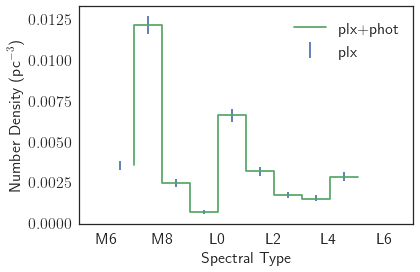

In [151]:
asymerr = [lfspt['comb_dens_unc_minus'],lfspt['comb_dens_unc_plus']]
#xspt = np.arange(17.5,26.5,1)
plt.errorbar(lfspt['sptn']-0.5,lfspt['comb_dens'],yerr=asymerr, drawstyle='steps',fmt='none')
plt.plot(lfspt['sptn'],lfspt['comb_dens'],drawstyle='steps')
plt.ylabel('Number Density (pc$^{-3}$)',fontsize=16)
plt.xlabel('Spectral Type',fontsize=16)
#plt.legend(['plx+phot','plx','phot'],fontsize=16)
plt.xlim(15,27)
plt.xticks(np.arange(6)*2+16,['M6','M8','L0','L2','L4','L6'])
print()

### could be that L0 covers a smaller mass or luminosity range than the others - this could be an effect from the abs mag relations

In [1124]:
lfmag.columns

Index(['MJ', 'Nsamp', 'Nplx', 'Nphot', 'sf_plx', 'sf_phot', 'Ncorr_comb',
       'comb_dens', 'comb_dens_unc'],
      dtype='object')

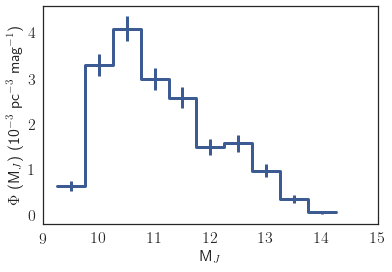

In [1125]:
plt.errorbar(lfmag['MJ']-0.25,lfmag['comb_dens']*10**3,yerr=lfmag['comb_dens_unc']*10**3,
             fmt='none', linewidth=3,ecolor=sns.xkcd_rgb['denim blue'])
plt.plot(lfmag['MJ'],lfmag['comb_dens']*10**3,drawstyle='steps',linewidth=3,color=sns.xkcd_rgb['denim blue'])
plt.xlabel('M$_J$',fontsize=16)
plt.xlim(9,15)
plt.ylabel('$\Phi$ (M$_J$) (10$^{-3}$ pc$^{-3}$ mag$^{-1}$)',fontsize=16)
plt.savefig(path+"LFmag.jpg", bbox_inches='tight')
print()

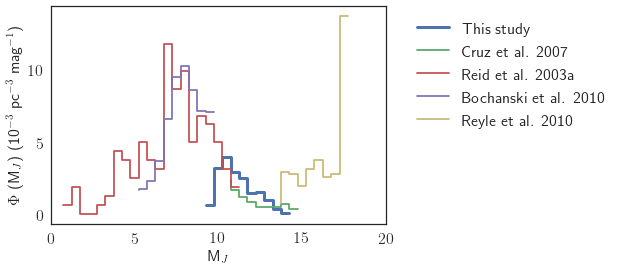

In [1115]:
plt.plot(lfmag['MJ'],lfmag['comb_dens']*10**3,drawstyle='steps',linewidth=3)
plt.plot(cruz07['MJ'],cruz07['rho']*10**3,drawstyle='steps')
plt.plot(reid8pc['MJ'],reid8pc['rho']*10**3,drawstyle='steps')
plt.plot(boch10['MJ'],boch10['rho']*10**3,drawstyle='steps')
plt.plot(reyle10['MJ'],reyle10['rho']*10**3,drawstyle='steps')
#plt.plot(lfmag['MJ'],lfmag['plx_dens'],drawstyle='steps')
#plt.plot(lfmag['MJ'],lfmag['phot_dens'],drawstyle='steps')plt.ylabel('Number Density (pc$^{-3}$)',fontsize=16)
plt.xlabel('M$_J$',fontsize=16)
plt.xlim(0,20)
plt.ylabel('$\Phi$ (M$_J$) (10$^{-3}$ pc$^{-3}$ mag$^{-1}$)',fontsize=16)
lgd = plt.legend(['This study','Cruz et al. 2007','Reid et al. 2003a','Bochanski et al. 2010','Reyle et al. 2010','plx','phot'],fontsize=16, bbox_to_anchor=(1.05,1))
plt.savefig(path+"LFcomparisons.jpg", bbox_extra_artists=(lgd,), bbox_inches='tight')
print()

In [1153]:
(368*20**3/99)**(1/3), (443*20**3/99)**(1/3), (99*25**3/368)**(1/3)

(30.981387973611213, 32.95739214810408, 16.13872175210101)

In [1141]:
lfmag.loc[10.75:14.75,'comb_dens'].values/cruz07['rho'].values

array([1.71302818, 1.79729105, 2.21425094, 1.79349297, 3.1225134 ,
       1.9242665 , 0.69159852, 0.06979107,        nan])

In [1162]:
lfmag.to_latex(path+"LFmag.tex",index=False)

In [1160]:
lfmag.columns

Index(['MJ', 'Nsamp', 'Nplx', 'Nphot', 'sf_plx', 'sf_phot', 'Ncorr_comb',
       'comb_dens', 'comb_dens_unc'],
      dtype='object')

In [1161]:
lfmag

,MJ,Nsamp,Nplx,Nphot,sf_plx,sf_phot,Ncorr_comb,comb_dens,comb_dens_unc
8.25,8.25,1,1,0,0.462500,0.000000,NaN,NaN,NaN
8.75,8.75,3,3,0,0.482935,0.000000,NaN,NaN,NaN
9.25,9.25,7,7,0,0.495400,0.000000,NaN,NaN,NaN
9.75,9.75,13,13,0,0.497949,0.106650,26.107089,0.000627,0.000117
10.25,10.25,58,46,12,0.497307,0.271706,136.663579,0.003283,0.000250
10.75,10.75,81,71,10,0.507693,0.334877,169.709915,0.004077,0.000275
11.25,11.25,60,55,5,0.499654,0.354220,124.191608,0.002984,0.000240
11.75,11.75,54,54,0,0.505060,0.322547,106.917939,0.002569,0.000225
12.25,12.25,30,28,2,0.505738,0.303035,61.964582,0.001489,0.000175
12.75,12.75,32,31,1,0.502720,0.300796,64.989032,0.001561,0.000179


In [1163]:
sfmag

,MJ,Nobj,Ntrue_sel,Nsel_plx,Nsel_phot,selected_obs_plx,selected_obs_phot,SFplx,SFphot
8.25,8.25,1797,240,624,0,111,0,0.462500,0.000000
8.75,8.75,13888,1758,4976,0,849,0,0.482935,0.000000
9.25,9.25,39368,4891,14115,0,2423,0,0.495400,0.000000
9.75,9.75,64752,8045,23419,7784,4006,858,0.497949,0.106650
10.25,10.25,87827,10953,31770,25809,5447,2976,0.497307,0.271706
10.75,10.75,113026,14038,41115,42382,7127,4701,0.507693,0.334877
11.25,11.25,124787,15911,45553,48831,7950,5636,0.499654,0.354220
11.75,11.75,117226,14525,42537,41366,7336,4685,0.505060,0.322547
12.25,12.25,106169,13246,38716,35255,6699,4014,0.505738,0.303035
12.75,12.75,101778,12683,36745,33182,6376,3815,0.502720,0.300796


#### Sanity check plots

Text(0,0.5,'NIR Distance (pc)')

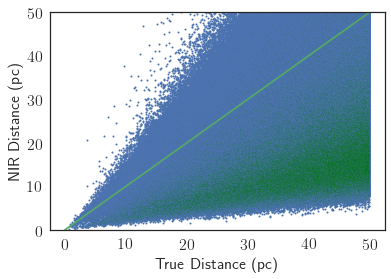

In [1060]:
plt.plot(simdf['true_dist'],simdf['obs_NIRdist'],'o',markersize=2)
plt.plot(simdf['true_dist'][simdf['binary_flag'] == 1],simdf['obs_NIRdist'][simdf['binary_flag'] == 1],'*',markersize=0.3,c='g')
plt.plot([0,50],[0,50])
plt.ylim(0,50)
plt.xlabel('True Distance (pc)',fontsize=16)
plt.ylabel('NIR Distance (pc)',fontsize=16)

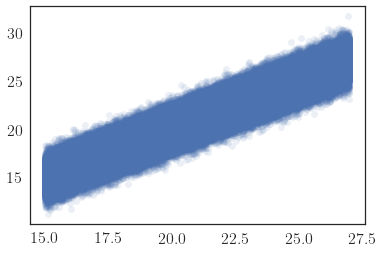

In [1061]:
plt.plot(simdf['true_sptn'],simdf['obs_sptn'],'o',alpha=0.1)

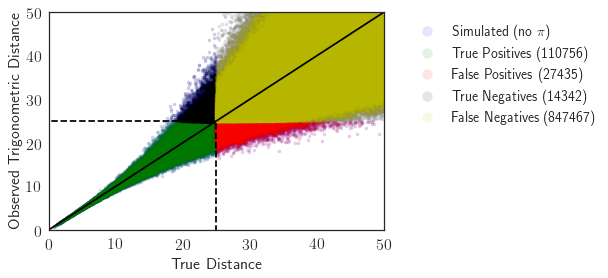

In [1062]:
plt.plot(simdf['true_dist'],simdf['obs_dist_plx'],'b.',alpha=0.1)
tp = simdf[(simdf['selected_intrinsic']==True) & (simdf['selected_obs_plx']==True)]
plt.plot(tp['true_dist'],tp['obs_dist_plx'],'g.',alpha=0.1)
fp = simdf[(simdf['selected_intrinsic']==False) & (simdf['selected_obs_plx']==True)]
plt.plot(fp['true_dist'],fp['obs_dist_plx'],'r.',alpha=0.1)
tn = simdf[(simdf['selected_intrinsic']==True) & (simdf['selected_obs_plx']==False)]
plt.plot(tn['true_dist'],tn['obs_dist_plx'],'k.',alpha=0.1)
fn = simdf[(simdf['selected_intrinsic']==False) & (simdf['selected_obs_plx']==False)]
plt.plot(fn['true_dist'],fn['obs_dist_plx'],'y.',alpha=0.1)
plt.plot([0,dsim],[0,dsim],'k-')
plt.plot([0,0,dlim,dlim],[0,dlim,dlim,0],'k--')
plt.xlim([0,dsim])
plt.ylim([0,dsim])
plt.xlabel('True Distance', fontsize=16)
plt.ylabel('Observed Trigonometric Distance', fontsize=16)
plt.legend([r'Simulated (no $\pi$)','True Positives ({})'.format(len(tp)),'False Positives ({})'.format(len(fp)),
            'True Negatives ({})'.format(len(tn)),'False Negatives ({})'.format(len(fn))], markerscale=3, scatterpoints=1,
           fontsize=14,  bbox_to_anchor=(1.05,1))

In [1063]:
simdf.columns

Index(['true_dist', 'true_sptn', 'true_plx', 'rel_MJ', 'rel_MH', 'rel_MK',
       'true_MJ', 'true_MH', 'true_MK', 'age', 'q', 'mass1', 'mass2', 'teff2',
       'spt2', 'MJ2', 'MH2', 'MK2', 'binary_flag', 'combMJ', 'combMH',
       'combMK', 'teff1', 'obs_sptn', 'comb_mJ', 'comb_mH', 'comb_mK',
       'obs_comb_mJ', 'obs_comb_mH', 'obs_comb_mK', 'obs_plx', 'obs_dist_plx',
       'obsMJ_plx', 'obsMH_plx', 'obsMK_plx', 'obsMJ_phot', 'obsMH_phot',
       'obsMK_phot', 'obs_Jdist_phot', 'obs_Hdist_phot', 'obs_Kdist_phot',
       'obs_NIRdist', 'selected_intrinsic', 'selected_obs_plx',
       'selected_obs_phot', 'true_sptn_bins', 'obs_sptn_bins', 'true_MJ_bins',
       'obs_MJplx_bins', 'obs_MJphot_bins'],
      dtype='object')

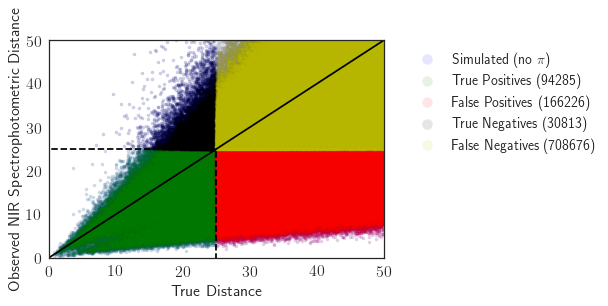

In [1064]:
plt.plot(simdf['true_dist'],simdf['obs_NIRdist'],'b.',alpha=0.1)
tp = simdf[(simdf['selected_intrinsic']==True) & (simdf['selected_obs_phot']==True)]
plt.plot(tp['true_dist'],tp['obs_NIRdist'],'g.',alpha=0.1)
fp = simdf[(simdf['selected_intrinsic']==False) & (simdf['selected_obs_phot']==True)]
plt.plot(fp['true_dist'],fp['obs_NIRdist'],'r.',alpha=0.1)
tn = simdf[(simdf['selected_intrinsic']==True) & (simdf['selected_obs_phot']==False)]
plt.plot(tn['true_dist'],tn['obs_NIRdist'],'k.',alpha=0.1)
fn = simdf[(simdf['selected_intrinsic']==False) & (simdf['selected_obs_phot']==False)]
plt.plot(fn['true_dist'],fn['obs_NIRdist'],'y.',alpha=0.1)
plt.plot([0,dsim],[0,dsim],'k-')
plt.plot([0,0,dlim,dlim],[0,dlim,dlim,0],'k--')
plt.xlim([0,dsim])
plt.ylim([0,dsim])
plt.xlabel('True Distance', fontsize=16)
plt.ylabel('Observed NIR Spectrophotometric Distance', fontsize=16)
plt.legend([r'Simulated (no $\pi$)','True Positives ({})'.format(len(tp)),'False Positives ({})'.format(len(fp)),
            'True Negatives ({})'.format(len(tn)),'False Negatives ({})'.format(len(fn))], markerscale=3, scatterpoints=1,
           fontsize=14,  bbox_to_anchor=(1.05,1))

Text(0,0.5,'Observed SpT')

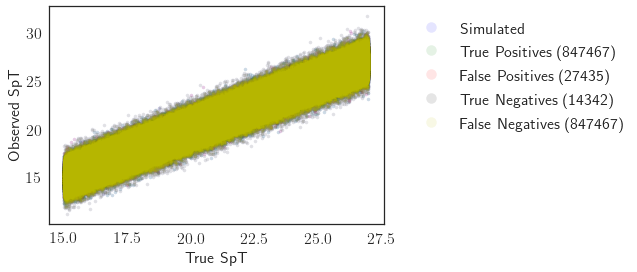

In [1065]:
plt.plot(simdf['true_sptn'],simdf['obs_sptn'],'b.',alpha=0.1)
plt.plot(simdf['true_sptn'][(simdf['selected_intrinsic']==True) & (simdf['selected_obs_plx']==True)],
         simdf['obs_sptn'][(simdf['selected_intrinsic']==True) & (simdf['selected_obs_plx']==True)],'g.',alpha=0.1)
tt = len(simdf[(simdf['selected_intrinsic']==False) & (simdf['selected_obs_plx']==False)])
plt.plot(simdf['true_sptn'][(simdf['selected_intrinsic']==False) & (simdf['selected_obs_plx']==True)],
         simdf['obs_sptn'][(simdf['selected_intrinsic']==False) & (simdf['selected_obs_plx']==True)],'r.',alpha=0.1)
ft = len(simdf[(simdf['selected_intrinsic']==False) & (simdf['selected_obs_plx']==True)])
plt.plot(simdf['true_sptn'][(simdf['selected_intrinsic']==True) & (simdf['selected_obs_plx']==False)],
         simdf['obs_sptn'][(simdf['selected_intrinsic']==True) & (simdf['selected_obs_plx']==False)],'k.',alpha=0.1)
tf = len(simdf[(simdf['selected_intrinsic']==True) & (simdf['selected_obs_plx']==False)])
plt.plot(simdf['true_sptn'][(simdf['selected_intrinsic']==False) & (simdf['selected_obs_plx']==False)],
         simdf['obs_sptn'][(simdf['selected_intrinsic']==False) & (simdf['selected_obs_plx']==False)],'y.',alpha=0.1)
ff = len(simdf[(simdf['selected_intrinsic']==False) & (simdf['selected_obs_plx']==False)])
plt.legend([r'Simulated','True Positives ({})'.format(tt),'False Positives ({})'.format(ft),'True Negatives ({})'.format(tf),
            'False Negatives ({})'.format(ff)], markerscale=3, scatterpoints=1, fontsize=16, bbox_to_anchor=(1.05,1))

plt.xlabel('True SpT',fontsize=16)
plt.ylabel('Observed SpT',fontsize=16)

In [1066]:
sfspt['sptn']

15.0    M5.0
15.5    M5.5
16.0    M6.0
16.5    M6.5
17.0    M7.0
17.5    M7.5
18.0    M8.0
18.5    M8.5
19.0    M9.0
19.5    M9.5
20.0    L0.0
20.5    L0.5
21.0    L1.0
21.5    L1.5
22.0    L2.0
22.5    L2.5
23.0    L3.0
23.5    L3.5
24.0    L4.0
24.5    L4.5
25.0    L5.0
25.5    L5.5
26.0    L6.0
26.5    L6.5
Name: sptn, dtype: object

In [1067]:
sfspt['sptn'] = sfspt['sptn'].map(lambda x: splat.typeToNum(x))

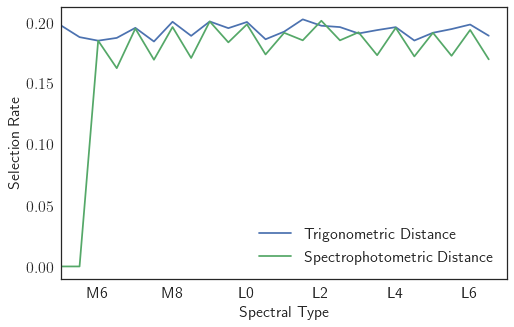

In [1068]:
plt.figure(figsize=[8,5])
plt.plot(sfspt['sptn'],sfspt['SFplx'])
plt.plot(sfspt['sptn'],sfspt['SFphot'])
plt.xlim(15,27)
plt.xticks(np.arange(6)*2+16,['M6','M8','L0','L2','L4','L6'])
plt.xlabel('Spectral Type',fontsize=16)
plt.ylabel('Selection Rate',fontsize=16)
plt.legend(['Trigonometric Distance','Spectrophotometric Distance'],fontsize=16)
plt.savefig('sfspt.jpg')

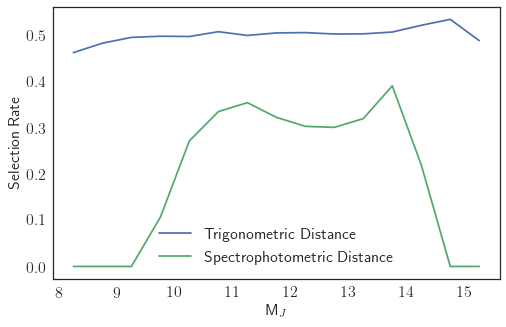

In [1069]:
plt.figure(figsize=[8,5])
plt.plot(sfmag['MJ'],sfmag['SFplx'])
plt.plot(sfmag['MJ'],sfmag['SFphot'])
plt.xlabel('M$_J$',fontsize=16)
plt.ylabel('Selection Rate',fontsize=16)
plt.legend(['Trigonometric Distance','Spectrophotometric Distance'],fontsize=16)
plt.savefig('sfmag.jpg')

(array([19937., 19977., 19931., 19985., 19851., 20255., 20043., 19876.,
        20093., 20053.]),
 array([15.00008121, 16.20007302, 17.40006482, 18.60005663, 19.80004843,
        21.00004024, 22.20003204, 23.40002385, 24.60001565, 25.80000746,
        26.99999926]),
 <a list of 10 Patch objects>)

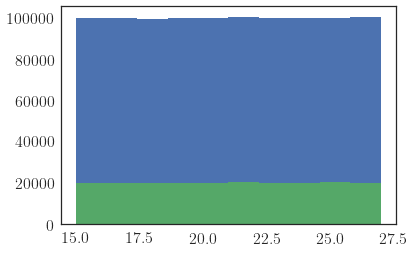

In [1070]:
plt.hist(simdf['true_sptn'])
plt.hist(simdf['true_sptn'][simdf['binary_flag'] == 1])

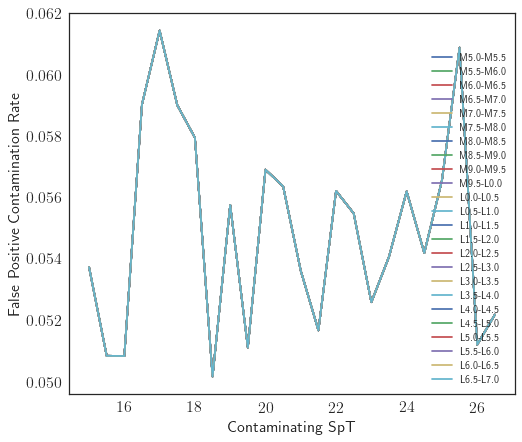

In [1071]:
# plot the false positive rate with parallaxes
plt.figure(figsize=[8,7])
leg = []
for s in fpspt['sptn']: 
    plt.plot(fpspt['sptn'],fpspt['%sel_plx'])
    leg.append('{}-{}'.format(splat.typeToNum(s),splat.typeToNum(s+spt_bin)))
plt.xlabel('Contaminating SpT',fontsize=16)
plt.ylabel('False Positive Contamination Rate',fontsize=16)
plt.legend(leg,)
#plt.xlim([np.min(fpspt['sptn']),np.max(fpspt['sptn'])+4])